# GDN

In [24]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

## SMAP dataset preparation

### Data import

In [25]:
# Configuration and File Paths
# Define the base directory where the SMAP data is located
BASE_DIR = './data' 
TRAIN_DATA_PATH = BASE_DIR + '/SMAP/SMAP/SMAP_train.npy'
TEST_DATA_PATH = BASE_DIR + '/SMAP/SMAP/SMAP_test.npy'
TEST_LABEL_PATH = BASE_DIR + '/SMAP/SMAP/SMAP_test_label.npy'
    
# Data Loading and Shape Inspection
print("--- Loading Raw Data ---")
try:
    X_train_raw = np.load(TRAIN_DATA_PATH)
    X_test_raw = np.load(TEST_DATA_PATH)
    y_test_raw = np.load(TEST_LABEL_PATH)
except FileNotFoundError as e:
    print(f"Error: {e}. Download the dataset and place it in the specified directory.")
    from torch_timeseries.dataset import SMAP
    SMAP(root=BASE_DIR)
    print("Dataset downloaded.")
    X_train_raw = np.load(TRAIN_DATA_PATH)
    X_test_raw = np.load(TEST_DATA_PATH)
    y_test_raw = np.load(TEST_LABEL_PATH)
print("Data Loaded Successfully.")
T_train, D_features = X_train_raw.shape
T_test, _ = X_test_raw.shape

--- Loading Raw Data ---
Data Loaded Successfully.


### Vizualization
Plotting sensor n°0,1,2,4 and 5.

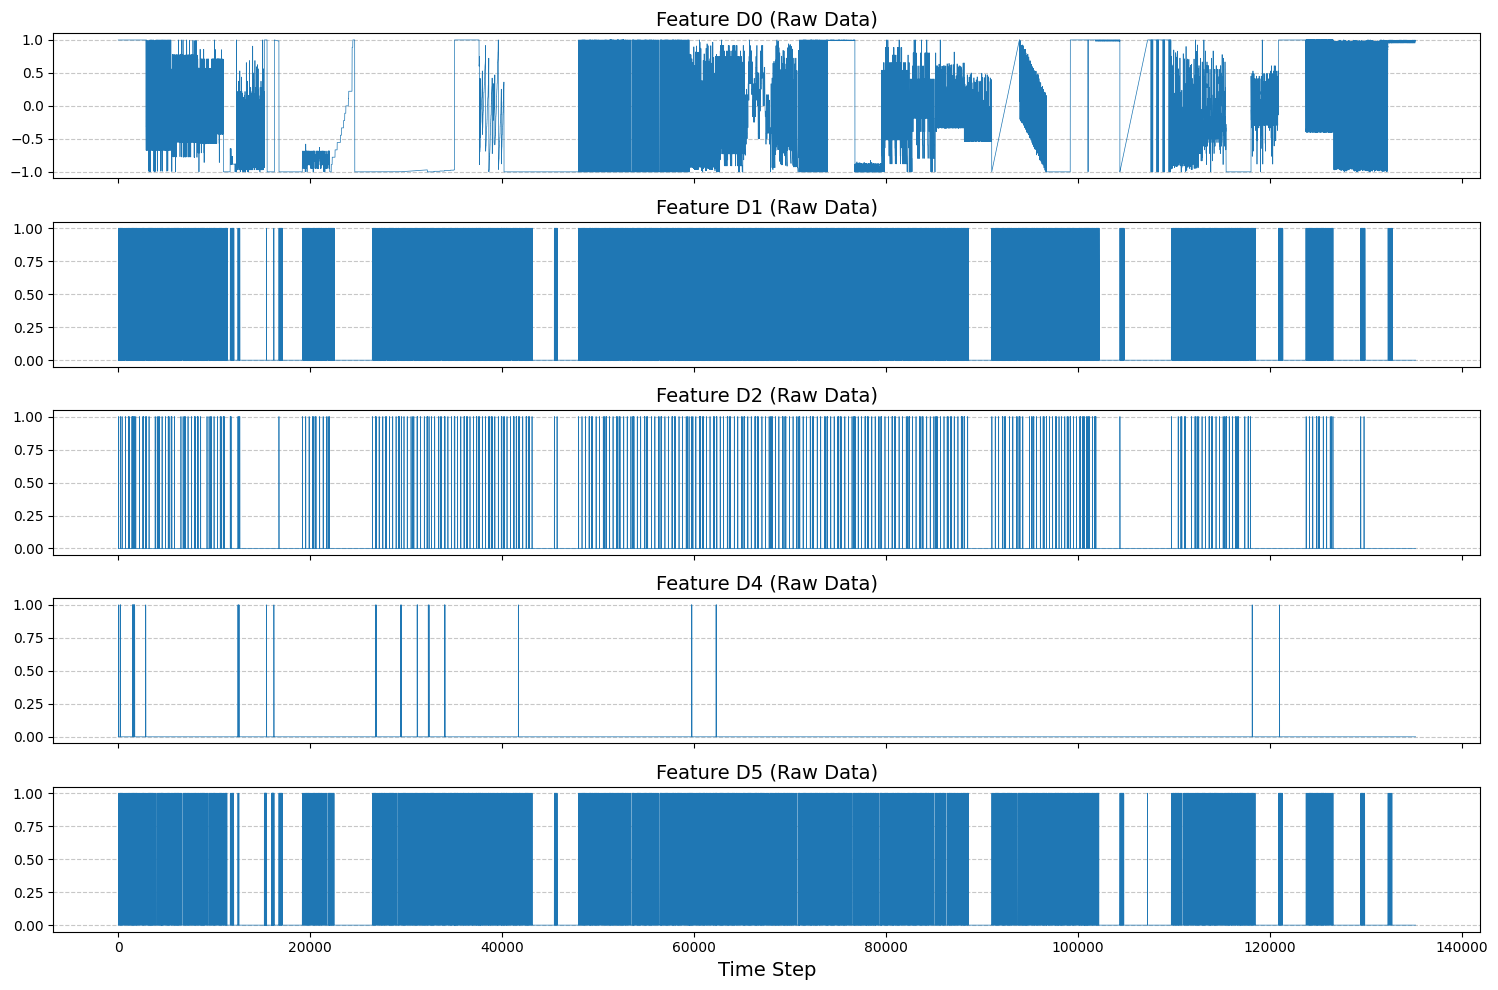

In [26]:
feature_indices = [0,1,2,4,5] 
features_to_plot = X_train_raw[:, feature_indices]
time_index = np.arange(T_train)

fig, axes = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
for i, feature_index in enumerate(feature_indices):
    ax = axes[i] 
    ax.plot(
        time_index, 
        features_to_plot[:, i], 
        label=f'Feature D{feature_index}', 
        linewidth=0.5
    )
    # Set title, labels, and grid
    ax.set_title(f'Feature D{feature_index} (Raw Data)', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

axes[4].set_xlabel('Time Step', fontsize=14)
plt.tight_layout()
plt.show()

Plotting the anomaly occurences

/tmp/ipykernel_440171/1927323803.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize=12)


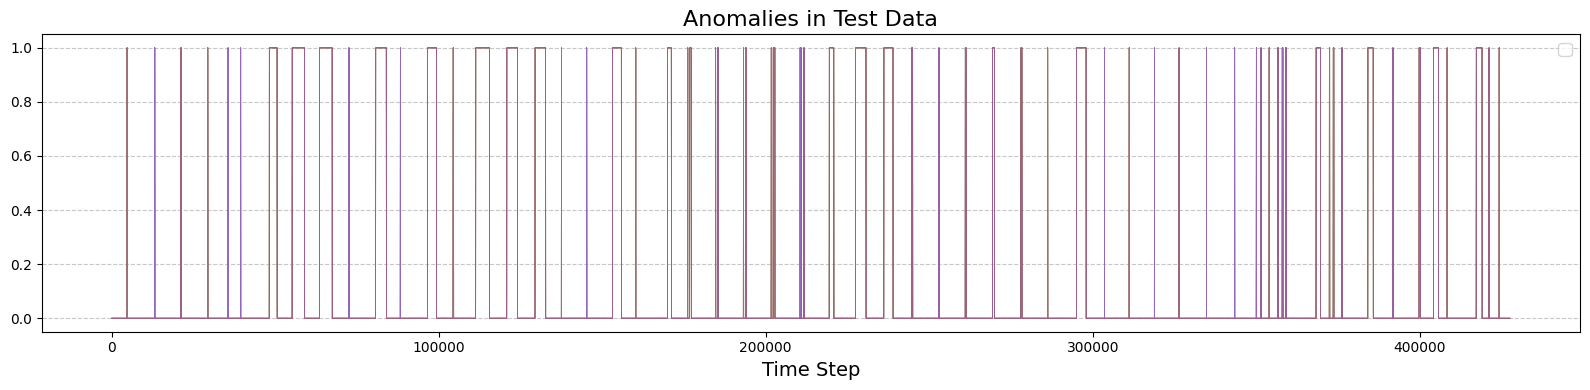

proportion of anomalies: 0.1279 in test set


In [27]:
plt.figure(figsize=(16, 4))
time_index = np.arange(T_test)
# Iterate through the selected features and plot them
for i, feature_index in enumerate(feature_indices):
    plt.plot(
        time_index, 
        y_test_raw,
        linewidth=0.5
    )

plt.title(f'Anomalies in Test Data', fontsize=16)
plt.xlabel('Time Step', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"proportion of anomalies: {np.mean(y_test_raw):.4f} in test set")

### Basic statistics

In [28]:
# --- Data Integrity Checks ---
def check_nan_inf(data, name):
    if np.isnan(data).any():
        print(f"Warning: {name} contains NaN values.")
    if np.isinf(data).any():
        print(f"Warning: {name} contains Inf values.")
    if not np.isnan(data).any() and not np.isinf(data).any():
        print(f"{name} contains no NaN or Inf values.")

# --- Basic Statistics ---

def basic_statistics(data):
    print(f"Length : {data.shape[0]}")
    print(f"Num of sensors (features): {data.shape[1]}")
    unique_val = {}
    repartition = [0,0]
    nb_continous = 0
    nb_discrete = 0
    for i in range(data.shape[1]):
        unique_vals, count = np.unique(data[:, i], return_counts=True)
        n_unique = len(unique_vals)
        if n_unique <= 2:
            for i in range(n_unique):
                if unique_vals[i] == 0:
                    repartition[0] += count[i]
                else:
                    repartition[1] += count[i]
            nb_discrete += 1
            str_unique = ', '.join(map(str, unique_vals))
            in_unique = False
            for k in unique_val.keys():
                if k == str_unique:
                    unique_val[k] += 1
                    in_unique = True
                    break
            if not in_unique:
                unique_val[str_unique] = 1 
        else:
            nb_continous += 1
    print(f"Number of continuous features: {nb_continous}")
    print(f"Number of discrete features: {nb_discrete}")
    print("Discrete feature value distributions:")
    for k, v in unique_val.items():
        print(f"    Values: [{k}] -> Count: {v} feature(s)")
    print(f"    Repartition of discrete feature values: "
          f"value 0 : {repartition[0]} ({100*repartition[0]/(repartition[0]+repartition[1]):.2f} %), " 
          f"value 1 : {repartition[1]} ({100*repartition[1]/(repartition[0]+repartition[1]):.2f} %)")

def stat_labels(labels):
    n_anomalies = np.sum(labels)
    n_normal = labels.shape[0] - n_anomalies
    print(f"Total number of points: {labels.shape[0]}")
    print(f"Number of normal points: {n_normal} ({100*n_normal/labels.shape[0]:.2f} %)")
    print(f"Number of anomalous points: {n_anomalies} ({100*n_anomalies/labels.shape[0]:.2f} %)")
    ongoing = 0
    nb_anomaly_sequences = 0
    nb_isolated_anomalies = 0
    length_anomaly_sequences = []
    for l in labels:
        if l == 1:
            ongoing += 1
        if l == 0:
            if ongoing > 1:
                nb_anomaly_sequences += 1
                length_anomaly_sequences.append(ongoing)
                ongoing = 0
            elif ongoing == 1:
                nb_isolated_anomalies += 1
                ongoing = 0
    if ongoing > 1:
        nb_anomaly_sequences += 1
    elif ongoing == 1:
        nb_isolated_anomalies += 1
    length_anomaly_sequences = np.array(length_anomaly_sequences)
    print(f"Number of isolated anomalies (length = 1): {nb_isolated_anomalies}")
    print(f"Number of anomaly sequences (length > 1): {nb_anomaly_sequences}")
    if length_anomaly_sequences.size > 0:
        print(f"    Anomaly sequence lengths -- Min: {np.min(length_anomaly_sequences)}, "
              f"    Max: {np.max(length_anomaly_sequences)}, "
              f"    Mean: {np.mean(length_anomaly_sequences):.2f}, "
              f"    Median: {np.median(length_anomaly_sequences)}")

In [29]:
check_nan_inf(X_train_raw, "X_train_raw")
check_nan_inf(X_test_raw, "X_test_raw")
check_nan_inf(y_test_raw, "y_test_raw")

print("\n--- Basic Statistics for X_train_raw ---")
basic_statistics(X_train_raw)

print("\n--- Basic Statistics for X_test_raw ---")
basic_statistics(X_test_raw)

print("\n--- Basic Statistics for y_test_raw ---")
stat_labels(y_test_raw)

X_train_raw contains no NaN or Inf values.
X_test_raw contains no NaN or Inf values.
y_test_raw contains no NaN or Inf values.

--- Basic Statistics for X_train_raw ---
Length : 135183
Num of sensors (features): 25
Number of continuous features: 1
Number of discrete features: 24
Discrete feature value distributions:
    Values: [0.0, 1.0] -> Count: 23 feature(s)
    Values: [0.0] -> Count: 1 feature(s)
    Repartition of discrete feature values: value 0 : 3191110 (98.36 %), value 1 : 53282 (1.64 %)

--- Basic Statistics for X_test_raw ---
Length : 427617
Num of sensors (features): 25
Number of continuous features: 1
Number of discrete features: 24
Discrete feature value distributions:
    Values: [0.0, 1.0] -> Count: 24 feature(s)
    Repartition of discrete feature values: value 0 : 10144228 (98.84 %), value 1 : 118580 (1.16 %)

--- Basic Statistics for y_test_raw ---
Total number of points: 427617
Number of normal points: 372921 (87.21 %)
Number of anomalous points: 54696 (12.79 %)
N

### Further analisis for stationarity, noise check

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

def analyze(x, sensor_id=0, window_var=200):
    T = len(x)
    
    # Signal plot
    plt.figure(figsize=(12,3))
    plt.plot(x)
    plt.title(f"Sensor {sensor_id} - Signal (raw)")
    plt.xlabel("Time")
    plt.show()

    # Local variance sliding window
    var_local = []
    for i in range(T - window_var):
        var_local.append(np.var(x[i:i+window_var]))
    var_local = np.array(var_local)
    
    plt.figure(figsize=(12,3))
    plt.plot(var_local)
    plt.title(f"Sensor {sensor_id} - Local variance (window={window_var})")
    plt.xlabel("Time")
    plt.show()
    
    # Autocorrelation function
    lag_acf = acf(x, nlags=200, fft=True)
    
    plt.figure(figsize=(12,3))
    plt.plot(range(len(lag_acf)), lag_acf)
    plt.title(f"Sensor {sensor_id} - Autocorrelation function")
    plt.xlabel("Lag")
    plt.show()
    
    # DFT Spectrum
    freqs = np.fft.rfftfreq(T)
    amp = np.abs(np.fft.rfft(x))

    plt.figure(figsize=(12,3))
    plt.plot(freqs, amp)
    plt.title(f"Sensor {sensor_id} - DFT Spectrum")
    plt.xlabel("Frequency")
    plt.show()


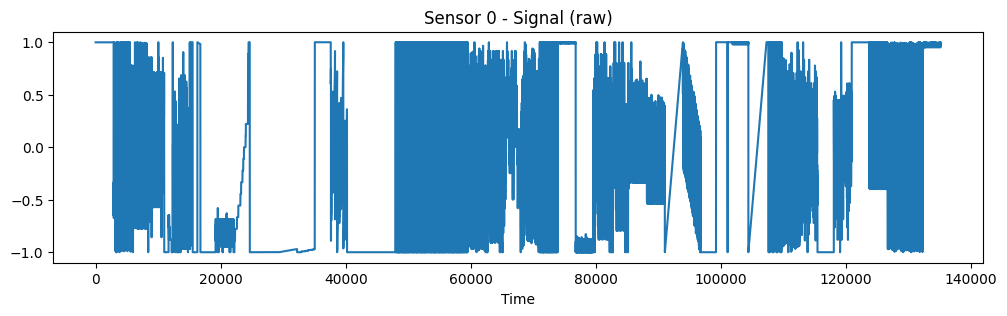

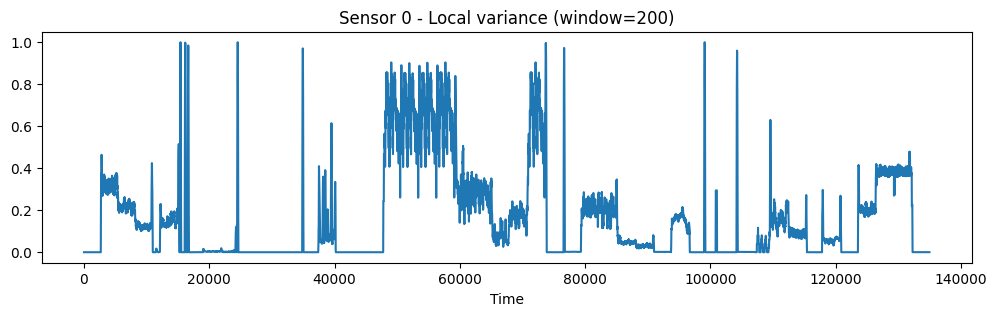

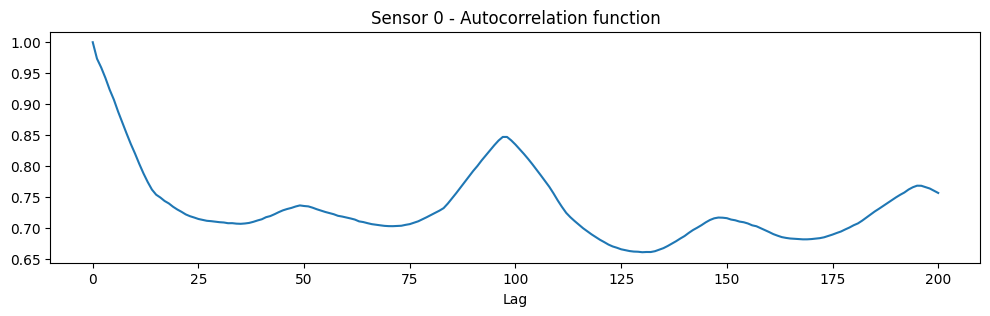

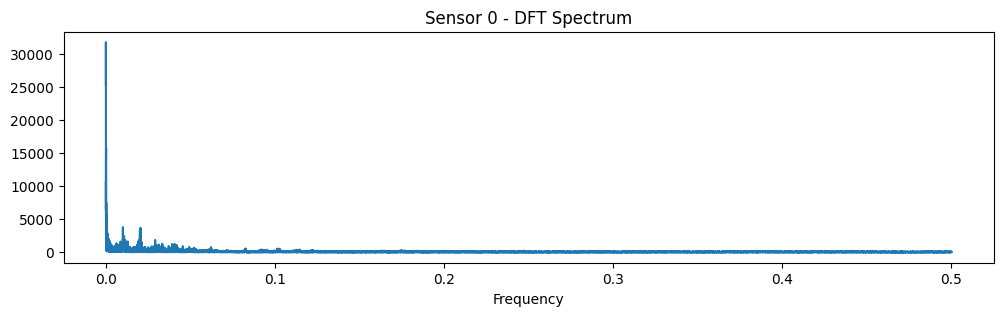

In [31]:
sensor_id = 0 # We choose the sensor we want to analyze
analyze(X_train_raw[:, sensor_id], sensor_id=sensor_id)

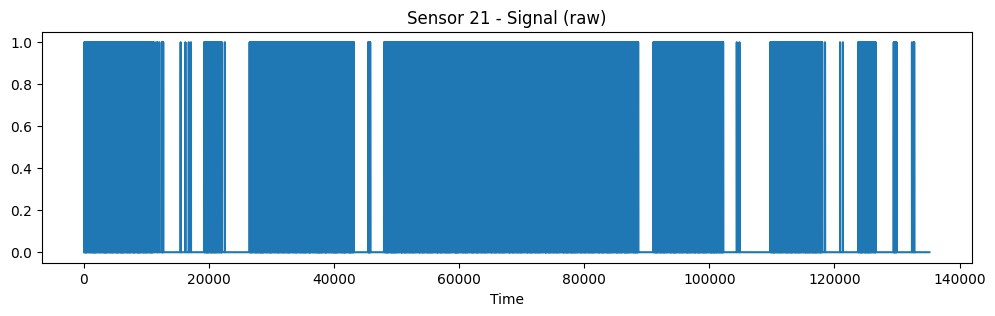

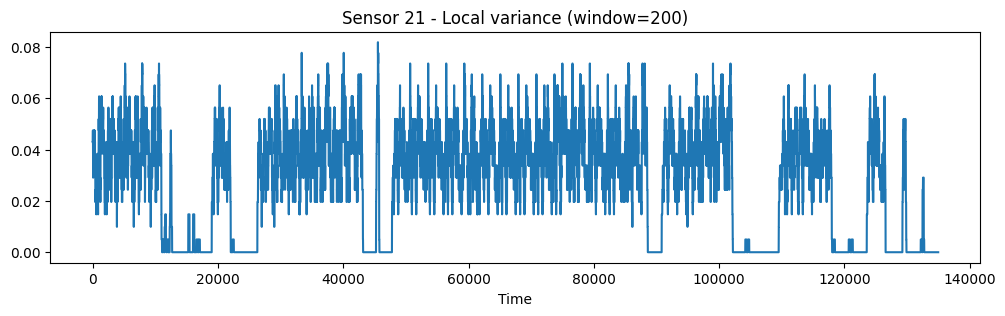

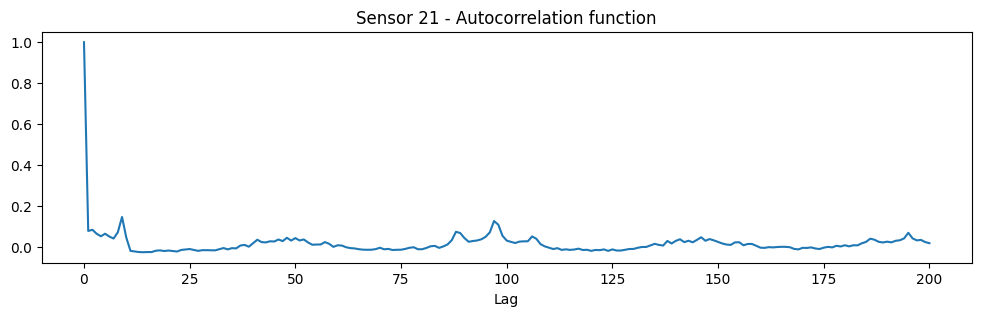

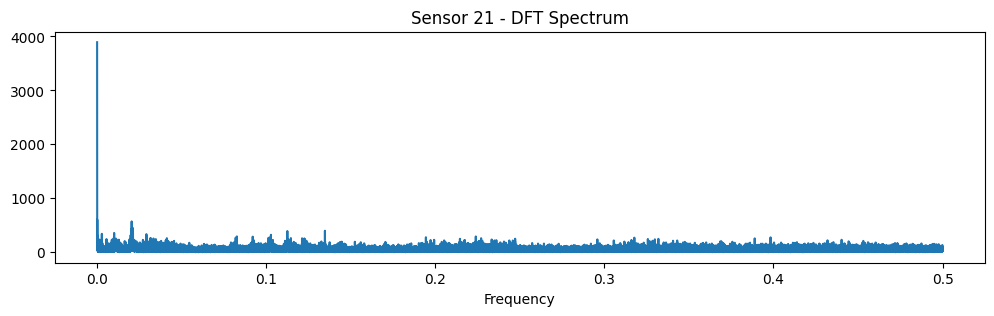

In [32]:
sensor_id = 21
analyze(X_train_raw[:, sensor_id], sensor_id=sensor_id)

### Detrending experimentation

In [33]:
import numpy as np

# Detrending function using least-squares polynomial fitting
def detrend_least_squares(x, order=1):
    """
    Remove polynomial trend
    """
    x = np.asarray(x)
    T = len(x)
    t = np.arange(T)

    # Construct design matrix B = [t^0, t^1, ..., t^order]
    B = np.vstack([t**k for k in range(order + 1)]).T

    # Least-squares fitting to find polynomial coefficients
    alpha_hat, _, _, _ = np.linalg.lstsq(B, x, rcond=None)

    # Trend reconstruction
    x_trend = B @ alpha_hat

    # Detrended signal
    x_detrended = x - x_trend

    return x_detrended, x_trend

In [34]:
sensor_id = 0   # sensor 0 

# TRAIN
x0_train = X_train_raw[:, sensor_id]
x0_train_detrended, trend_train = detrend_least_squares(x0_train, order=2)

# TEST
x0_test = X_test_raw[:, sensor_id]
x0_test_detrended, trend_test = detrend_least_squares(x0_test, order=2)

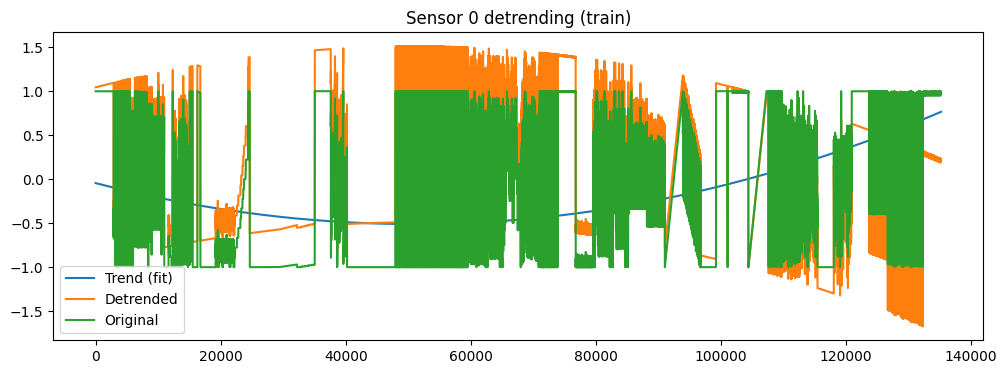

In [35]:
plt.figure(figsize=(12,4))

plt.plot(trend_train, label="Trend (fit)")
plt.plot(x0_train_detrended, label="Detrended")
plt.plot(x0_train, label="Original")
plt.legend()
plt.title("Sensor 0 detrending (train)")
plt.show()

### Build dataloader for GDN model
We need sliding windows

In [36]:
# Model parameters
WINDOW_SIZE = 5
PREDICTION_HORIZON = 1
BATCH_SIZE = 64
val_size = 0.2

In [37]:
def create_sliding_windows(data, window_size):
    """
    Creates overlapping sequences (sliding windows) from the time series data.
    Input: (T, D) -> Output: (N_samples, D, Window_Size)
    """
    N_time, N_dims = data.shape
    windows = []
    # Loop from 0 up to the point where a full window can be created
    for i in range(N_time - window_size):
        windows.append(data[i : i + window_size, :].T) # Transpose to (D, Window_Size) 
    return np.array(windows)

# Create windows for training data (X_train) and testing data (X_test) X_test will be split into test and validation sets
X_train_windows = create_sliding_windows(X_train_raw, WINDOW_SIZE)
X_test_windows = create_sliding_windows(X_test_raw, WINDOW_SIZE)

# For anomaly detection, the GDN model needs to predict the *next* time step (t+1).
# The target y is the time step *after* the window: data[i + window_size, :]
# The anomaly detection target y_test_label is for the predicted point (t+1).
y_train_windows = X_train_raw[WINDOW_SIZE:, :]  # Target is the next point
y_test_windows = X_test_raw[WINDOW_SIZE:, :]
y_test_labels_windows = y_test_raw[WINDOW_SIZE:] # Anomaly label for the predicted point

print(f"\nX_train_windows shape: {X_train_windows.shape}") 
print(f"y_train_windows shape: {y_train_windows.shape}")
print(f"X_test_windows shape: {X_test_windows.shape}")
print(f"y_test_windows shape: {y_test_windows.shape}")
print(f"y_test_labels_windows shape: {y_test_labels_windows.shape}")

# We take a validation set from the training data
N_train = X_train_windows.shape[0]
N_val = int(val_size * N_train)

X_val_windows = X_train_windows[:N_val]
y_val_windows = y_train_windows[:N_val]

X_train_windows = X_train_windows[N_val:]
y_train_windows = y_train_windows[N_val:]

print("\nValidation split:")
print("  X_val_windows:", X_val_windows.shape)
print("  y_val_windows:", y_val_windows.shape)

print("\nFinal train split:")
print("  X_train_windows_final:", X_train_windows.shape)
print("  y_train_windows_final:", y_train_windows.shape)

print("\nFinal test split:")
print("  X_test_windows_final:", X_test_windows.shape)
print("  y_test_windows_final:", y_test_windows.shape)
print("  y_test_labels_final:", y_test_labels_windows.shape)

# PyTorch DataLoader Creation
import numpy as np
X_train_tensor = torch.from_numpy(X_train_windows)
y_train_tensor = torch.from_numpy(y_train_windows)

X_val_tensor = torch.from_numpy(X_val_windows)
y_val_tensor = torch.from_numpy(y_val_windows)

X_test_tensor = torch.from_numpy(X_test_windows)
y_test_tensor = torch.from_numpy(y_test_windows)
y_test_labels_tensor = torch.from_numpy(y_test_labels_windows)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, y_test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\n--- DataLoader Creation Complete ---")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of testing batches: {len(test_loader)}")
print("Data is ready for the GDN model training.")


X_train_windows shape: (135178, 25, 5)
y_train_windows shape: (135178, 25)
X_test_windows shape: (427612, 25, 5)
y_test_windows shape: (427612, 25)
y_test_labels_windows shape: (427612,)

Validation split:
  X_val_windows: (27035, 25, 5)
  y_val_windows: (27035, 25)

Final train split:
  X_train_windows_final: (108143, 25, 5)
  y_train_windows_final: (108143, 25)

Final test split:
  X_test_windows_final: (427612, 25, 5)
  y_test_windows_final: (427612, 25)
  y_test_labels_final: (427612,)

--- DataLoader Creation Complete ---
Number of training batches: 1690
Number of validation batches: 423
Number of testing batches: 6682
Data is ready for the GDN model training.


## Model code from the paper


In [38]:
import torch
from torch.nn import Parameter, Linear, Sequential, BatchNorm1d, ReLU
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

from torch_geometric.nn.inits import glorot, zeros
import time
import math

class GraphLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=1, concat=True,
                 negative_slope=0.2, dropout=0, bias=True, inter_dim=-1,**kwargs):
        super(GraphLayer, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.node_dim = 0

        self.__alpha__ = None

        self.lin = Linear(in_channels, heads * out_channels, bias=False)

        self.att_i = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_j = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_em_i = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_em_j = Parameter(torch.Tensor(1, heads, out_channels))

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.lin.weight)
        glorot(self.att_i)
        glorot(self.att_j)
        
        zeros(self.att_em_i)
        zeros(self.att_em_j)

        zeros(self.bias)



    def forward(self, x, edge_index, embedding, return_attention_weights=False):
        """"""
        if torch.is_tensor(x):
            x = self.lin(x)
            x = (x, x)
        else:
            x = (self.lin(x[0]), self.lin(x[1]))

        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index,
                                       num_nodes=x[1].size(self.node_dim))

        out = self.propagate(edge_index, x=x, embedding=embedding, edges=edge_index,
                             return_attention_weights=return_attention_weights)

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)

        if self.bias is not None:
            out = out + self.bias

        if return_attention_weights:
            alpha, self.__alpha__ = self.__alpha__, None
            return out, (edge_index, alpha)
        else:
            return out

    def message(self, x_i, x_j, edge_index_i, size_i,
                embedding,
                edges,
                return_attention_weights):

        x_i = x_i.view(-1, self.heads, self.out_channels)
        x_j = x_j.view(-1, self.heads, self.out_channels)

        if embedding is not None:
            embedding_i, embedding_j = embedding[edge_index_i], embedding[edges[0]]
            embedding_i = embedding_i.unsqueeze(1).repeat(1,self.heads,1)
            embedding_j = embedding_j.unsqueeze(1).repeat(1,self.heads,1)

            key_i = torch.cat((x_i, embedding_i), dim=-1)
            key_j = torch.cat((x_j, embedding_j), dim=-1)



        cat_att_i = torch.cat((self.att_i, self.att_em_i), dim=-1)
        cat_att_j = torch.cat((self.att_j, self.att_em_j), dim=-1)

        alpha = (key_i * cat_att_i).sum(-1) + (key_j * cat_att_j).sum(-1) # alpha: (E, heads)
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = alpha.mean(dim=1)          # (E,)
        alpha = softmax(alpha, edge_index_i)   # (E,)
        alpha = alpha.view(-1, 1, 1)       # (E, 1, 1)

        if return_attention_weights:
            self.__alpha__ = alpha

        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        # x_j: (E, heads, out_channels) = (E, 1, out_channels)
        # alpha: (E, 1, 1)
        return x_j * alpha



    def __repr__(self):
        return '{}({}, {}, heads={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.heads)


In [39]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from torch_geometric.nn import GCNConv, GATConv, EdgeConv
import math
import torch.nn.functional as F


def get_batch_edge_index(org_edge_index, batch_num, node_num):
    # org_edge_index:(2, edge_num)
    edge_index = org_edge_index.clone().detach()
    edge_num = org_edge_index.shape[1]
    batch_edge_index = edge_index.repeat(1,batch_num).contiguous()

    for i in range(batch_num):
        batch_edge_index[:, i*edge_num:(i+1)*edge_num] += i*node_num

    return batch_edge_index.long()


class OutLayer(nn.Module):
    def __init__(self, in_num, node_num, layer_num, inter_num = 512):
        super(OutLayer, self).__init__()

        modules = []

        for i in range(layer_num):
            # last layer, output shape:1
            if i == layer_num-1:
                modules.append(nn.Linear( in_num if layer_num == 1 else inter_num, 1))
            else:
                layer_in_num = in_num if i == 0 else inter_num
                modules.append(nn.Linear( layer_in_num, inter_num ))
                modules.append(nn.BatchNorm1d(inter_num))
                modules.append(nn.ReLU())

        self.mlp = nn.ModuleList(modules)

    def forward(self, x):
        out = x

        for mod in self.mlp:
            if isinstance(mod, nn.BatchNorm1d):
                out = out.permute(0,2,1)
                out = mod(out)
                out = out.permute(0,2,1)
            else:
                out = mod(out)

        return out



class GNNLayer(nn.Module):
    def __init__(self, in_channel, out_channel, inter_dim=0, heads=1, node_num=100):
        super(GNNLayer, self).__init__()


        self.gnn = GraphLayer(in_channel, out_channel, inter_dim=inter_dim, heads=heads, concat=False)

        self.bn = nn.BatchNorm1d(out_channel)
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x, edge_index, embedding=None, node_num=0):

        out, (new_edge_index, att_weight) = self.gnn(x, edge_index, embedding, return_attention_weights=True)
        self.att_weight_1 = att_weight
        self.edge_index_1 = new_edge_index
  
        out = self.bn(out)
        
        return self.relu(out)


class GDN(nn.Module):
    def __init__(self, edge_index_sets, node_num, dim=64, out_layer_inter_dim=256, input_dim=10, out_layer_num=1, topk=20):

        super(GDN, self).__init__()

        self.edge_index_sets = edge_index_sets

        device = get_device()

        edge_index = edge_index_sets[0]


        embed_dim = dim
        self.embedding = nn.Embedding(node_num, embed_dim)
        self.bn_outlayer_in = nn.BatchNorm1d(embed_dim)


        edge_set_num = len(edge_index_sets)
        self.gnn_layers = nn.ModuleList([
            GNNLayer(input_dim, dim, inter_dim=dim+embed_dim, heads=1) for i in range(edge_set_num)
        ])


        self.node_embedding = None
        self.topk = topk
        self.learned_graph = None

        self.out_layer = OutLayer(dim*edge_set_num, node_num, out_layer_num, inter_num = out_layer_inter_dim)

        self.cache_edge_index_sets = [None] * edge_set_num
        self.cache_embed_index = None

        self.dp = nn.Dropout(0.2)

        self.init_params()
    
    def init_params(self):
        nn.init.kaiming_uniform_(self.embedding.weight, a=math.sqrt(5))


    def forward(self, data, org_edge_index):

        x = data.clone().detach()
        edge_index_sets = self.edge_index_sets

        device = data.device

        batch_num, node_num, all_feature = x.shape
        x = x.view(-1, all_feature).contiguous()


        gcn_outs = []
        for i, edge_index in enumerate(edge_index_sets):
            edge_num = edge_index.shape[1]
            cache_edge_index = self.cache_edge_index_sets[i]

            if cache_edge_index is None or cache_edge_index.shape[1] != edge_num*batch_num:
                self.cache_edge_index_sets[i] = get_batch_edge_index(edge_index, batch_num, node_num).to(device)
            
            batch_edge_index = self.cache_edge_index_sets[i]
            
            all_embeddings = self.embedding(torch.arange(node_num).to(device))

            weights_arr = all_embeddings.detach().clone()
            all_embeddings = all_embeddings.repeat(batch_num, 1)

            weights = weights_arr.view(node_num, -1)

            cos_ji_mat = torch.matmul(weights, weights.T)
            normed_mat = torch.matmul(weights.norm(dim=-1).view(-1,1), weights.norm(dim=-1).view(1,-1))
            cos_ji_mat = cos_ji_mat / normed_mat

            dim = weights.shape[-1]
            topk_num = self.topk

            topk_indices_ji = torch.topk(cos_ji_mat, topk_num, dim=-1)[1]

            self.learned_graph = topk_indices_ji

            gated_i = torch.arange(0, node_num).T.unsqueeze(1).repeat(1, topk_num).flatten().to(device).unsqueeze(0)
            gated_j = topk_indices_ji.flatten().unsqueeze(0)
            gated_edge_index = torch.cat((gated_j, gated_i), dim=0)

            batch_gated_edge_index = get_batch_edge_index(gated_edge_index, batch_num, node_num).to(device)
            gcn_out = self.gnn_layers[i](x, batch_gated_edge_index, node_num=node_num*batch_num, embedding=all_embeddings)

            
            gcn_outs.append(gcn_out)

        x = torch.cat(gcn_outs, dim=1)
        x = x.view(batch_num, node_num, -1)


        indexes = torch.arange(0,node_num).to(device)
        out = torch.mul(x, self.embedding(indexes))
        
        out = out.permute(0,2,1)
        out = F.relu(self.bn_outlayer_in(out))
        out = out.permute(0,2,1)

        out = self.dp(out)
        out = self.out_layer(out)
        out = out.view(-1, node_num)
   

        return out
        

## Graph construction code from the paper

We do not use this part. (On peut supprimer mais je le garde pour l'instant)

In [40]:
# preprocess data
import numpy as np
import re


def get_most_common_features(target, all_features, max = 3, min = 3):
    res = []
    main_keys = target.split('_')

    for feature in all_features:
        if target == feature:
            continue

        f_keys = feature.split('_')
        common_key_num = len(list(set(f_keys) & set(main_keys)))

        if common_key_num >= min and common_key_num <= max:
            res.append(feature)

    return res

def build_net(target, all_features):
    # get edge_indexes, and index_feature_map
    main_keys = target.split('_')
    edge_indexes = [
        [],
        []
    ]
    index_feature_map = [target]

    # find closest features(nodes):
    parent_list = [target]
    graph_map = {}
    depth = 2
    
    for i in range(depth):        
        for feature in parent_list:
            children = get_most_common_features(feature, all_features)

            if feature not in graph_map:
                graph_map[feature] = []
            
            # exclude parent
            pure_children = []
            for child in children:
                if child not in graph_map:
                    pure_children.append(child)

            graph_map[feature] = pure_children

            if feature not in index_feature_map:
                index_feature_map.append(feature)
            p_index = index_feature_map.index(feature)
            for child in pure_children:
                if child not in index_feature_map:
                    index_feature_map.append(child)
                c_index = index_feature_map.index(child)

                edge_indexes[1].append(p_index)
                edge_indexes[0].append(c_index)

        parent_list = pure_children

    return edge_indexes, index_feature_map


def construct_data(data, feature_map, labels=0):
    res = []

    for feature in feature_map:
        if feature in data.columns:
            res.append(data.loc[:, feature].values.tolist())
        else:
            print(feature, 'not exist in data')
    # append labels as last
    sample_n = len(res[0])

    if type(labels) == int:
        res.append([labels]*sample_n)
    elif len(labels) == sample_n:
        res.append(labels)

    return res

def build_loc_net(struc, all_features, feature_map=[]):

    index_feature_map = feature_map
    edge_indexes = [
        [],
        []
    ]
    for node_name, node_list in struc.items():
        if node_name not in all_features:
            continue

        if node_name not in index_feature_map:
            index_feature_map.append(node_name)
        
        p_index = index_feature_map.index(node_name)
        for child in node_list:
            if child not in all_features:
                continue

            if child not in index_feature_map:
                print(f'error: {child} not in index_feature_map')
                # index_feature_map.append(child)

            c_index = index_feature_map.index(child)
            # edge_indexes[0].append(p_index)
            # edge_indexes[1].append(c_index)
            edge_indexes[0].append(c_index)
            edge_indexes[1].append(p_index)
        

    
    return edge_indexes

In [41]:
import glob


def get_feature_map(dataset):
    feature_file = open(f'./data/{dataset}/list.txt', 'r')
    feature_list = []
    for ft in feature_file:
        feature_list.append(ft.strip())

    return feature_list
# graph is 'fully-connect'
def get_fc_graph_struc(dataset):
    feature_file = open(f'./data/{dataset}/list.txt', 'r')

    struc_map = {}
    feature_list = []
    for ft in feature_file:
        feature_list.append(ft.strip())

    for ft in feature_list:
        if ft not in struc_map:
            struc_map[ft] = []

        for other_ft in feature_list:
            if other_ft is not ft:
                struc_map[ft].append(other_ft)
    
    return struc_map

def get_prior_graph_struc(dataset):
    feature_file = open(f'./data/{dataset}/features.txt', 'r')

    struc_map = {}
    feature_list = []
    for ft in feature_file:
        feature_list.append(ft.strip())

    for ft in feature_list:
        if ft not in struc_map:
            struc_map[ft] = []
        for other_ft in feature_list:
            if dataset == 'wadi' or dataset == 'wadi2':
                # same group, 1_xxx, 2A_xxx, 2_xxx
                if other_ft is not ft and other_ft[0] == ft[0]:
                    struc_map[ft].append(other_ft)
            elif dataset == 'swat':
                # FIT101, PV101
                if other_ft is not ft and other_ft[-3] == ft[-3]:
                    struc_map[ft].append(other_ft)

    
    return struc_map

## Evaluation functions from the paper

In [42]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score


def get_full_err_scores(test_result, val_result):
    np_test_result = np.array(test_result)
    np_val_result = np.array(val_result)

    all_scores =  None
    all_normals = None
    feature_num = np_test_result.shape[-1]

    labels = np_test_result[2, :, 0].tolist()

    for i in range(feature_num):
        test_re_list = np_test_result[:2,:,i]
        val_re_list = np_val_result[:2,:,i]

        scores = get_err_scores(test_re_list, val_re_list)
        normal_dist = get_err_scores(val_re_list, val_re_list)

        if all_scores is None:
            all_scores = scores
            all_normals = normal_dist
        else:
            all_scores = np.vstack((
                all_scores,
                scores
            ))
            all_normals = np.vstack((
                all_normals,
                normal_dist
            ))

    return all_scores, all_normals


def get_final_err_scores(test_result, val_result):
    full_scores, all_normals = get_full_err_scores(test_result, val_result, return_normal_scores=True)

    all_scores = np.max(full_scores, axis=0)

    return all_scores



def get_err_scores(test_res, val_res):
    test_predict, test_gt = test_res
    val_predict, val_gt = val_res

    n_err_mid, n_err_iqr = get_err_median_and_iqr(test_predict, test_gt)

    test_delta = np.abs(np.subtract(
                        np.array(test_predict).astype(np.float64), 
                        np.array(test_gt).astype(np.float64)
                    ))
    epsilon=1e-2

    err_scores = (test_delta - n_err_mid) / ( np.abs(n_err_iqr) +epsilon)

    smoothed_err_scores = np.zeros(err_scores.shape)
    before_num = 3
    for i in range(before_num, len(err_scores)):
        smoothed_err_scores[i] = np.mean(err_scores[i-before_num:i+1])

    
    return smoothed_err_scores



def get_loss(predict, gt):
    return eval_mseloss(predict, gt)

def get_f1_scores(total_err_scores, gt_labels, topk=1):
    print('total_err_scores', total_err_scores.shape)
    # remove the highest and lowest score at each timestep
    total_features = total_err_scores.shape[0]

    # topk_indices = np.argpartition(total_err_scores, range(total_features-1-topk, total_features-1), axis=0)[-topk-1:-1]
    topk_indices = np.argpartition(total_err_scores, range(total_features-topk-1, total_features), axis=0)[-topk:]
    
    topk_indices = np.transpose(topk_indices)

    total_topk_err_scores = []
    topk_err_score_map=[]
    # topk_anomaly_sensors = []

    for i, indexs in enumerate(topk_indices):
       
        sum_score = sum( score for k, score in enumerate(sorted([total_err_scores[index, i] for j, index in enumerate(indexs)])) )

        total_topk_err_scores.append(sum_score)

    final_topk_fmeas = eval_scores(total_topk_err_scores, gt_labels, 400)

    return final_topk_fmeas

def get_val_performance_data(total_err_scores, normal_scores, gt_labels, topk=1):
    total_features = total_err_scores.shape[0]

    topk_indices = np.argpartition(total_err_scores, range(total_features-topk-1, total_features), axis=0)[-topk:]

    total_topk_err_scores = []
    topk_err_score_map=[]

    total_topk_err_scores = np.sum(np.take_along_axis(total_err_scores, topk_indices, axis=0), axis=0)

    thresold = np.max(normal_scores)

    pred_labels = np.zeros(len(total_topk_err_scores))
    pred_labels[total_topk_err_scores > thresold] = 1

    for i in range(len(pred_labels)):
        pred_labels[i] = int(pred_labels[i])
        gt_labels[i] = int(gt_labels[i])

    pre = precision_score(gt_labels, pred_labels)
    rec = recall_score(gt_labels, pred_labels)

    f1 = f1_score(gt_labels, pred_labels)


    auc_score = roc_auc_score(gt_labels, total_topk_err_scores)

    return f1, pre, rec, auc_score, thresold


def get_best_performance_data(total_err_scores, gt_labels, topk=1):

    total_features = total_err_scores.shape[0]

    # topk_indices = np.argpartition(total_err_scores, range(total_features-1-topk, total_features-1), axis=0)[-topk-1:-1]
    topk_indices = np.argpartition(total_err_scores, range(total_features-topk-1, total_features), axis=0)[-topk:]

    total_topk_err_scores = []
    topk_err_score_map=[]

    total_topk_err_scores = np.sum(np.take_along_axis(total_err_scores, topk_indices, axis=0), axis=0)

    final_topk_fmeas ,thresolds = eval_scores(total_topk_err_scores, gt_labels, 400, return_thresold=True)

    th_i = final_topk_fmeas.index(max(final_topk_fmeas))
    thresold = thresolds[th_i]

    pred_labels = np.zeros(len(total_topk_err_scores))
    pred_labels[total_topk_err_scores > thresold] = 1

    for i in range(len(pred_labels)):
        pred_labels[i] = int(pred_labels[i])
        gt_labels[i] = int(gt_labels[i])

    pre = precision_score(gt_labels, pred_labels)
    rec = recall_score(gt_labels, pred_labels)

    auc_score = roc_auc_score(gt_labels, total_topk_err_scores)

    return max(final_topk_fmeas), pre, rec, auc_score, thresold


## Train code adapted from the paper

In [43]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from sklearn.metrics import mean_squared_error
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from torch.utils.data import DataLoader, random_split, Subset
from scipy.stats import iqr




def loss_func(y_pred, y_true):
    loss = F.mse_loss(y_pred, y_true, reduction='mean')

    return loss


def train(
    model=None,
    save_path='',
    config={},
    train_dataloader=None,
    val_dataloader=None,
    feature_map={},
    test_dataloader=None,
    test_dataset=None,
    dataset_name='smap',
    train_dataset=None
):
    seed = config['seed']
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=config['decay'])

    now = time.time()
    train_loss_list = []

    device = get_device()

    acu_loss = 0
    min_loss = 1e+8

    epoch = config['epoch']
    early_stop_win = 15
    stop_improve_count = 0

    model.train()

    dataloader = train_dataloader

    for i_epoch in range(epoch):

        acu_loss = 0.0
        model.train()

        for batch in dataloader:
            # loaders with 2 elements: (x, y)
            x, labels = batch     # labels = y_true
            edge_index = model.edge_index_sets[0].to(device)

            x = x.float().to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            out = model(x, edge_index).float().to(device)
            loss = loss_func(out, labels)

            loss.backward()
            optimizer.step()

            train_loss_list.append(loss.item())
            acu_loss += loss.item()

        # each epoch
        print('epoch ({} / {}) (Loss:{:.8f}, ACU_loss:{:.8f})'.format(
            i_epoch + 1, epoch,
            acu_loss / len(dataloader), acu_loss
        ), flush=True)

        # early stopping on val loss
        if val_dataloader is not None:
            val_loss, val_result = test(model, val_dataloader)

            if val_loss < min_loss:
                torch.save(model.state_dict(), save_path)
                min_loss = val_loss
                stop_improve_count = 0
            else:
                stop_improve_count += 1

            if stop_improve_count >= early_stop_win:
                break

        else:
            # pas de val → on garde le meilleur loss train
            if acu_loss < min_loss:
                torch.save(model.state_dict(), save_path)
                min_loss = acu_loss

    return train_loss_list

## Test code adapted from the paper

In [44]:
import torch
import torch.nn as nn

def test(model, dataloader):
    """
    Generic test function for:
      - val_loader: batches of (x, y)
      - test_loader: batches of (x, y, labels)

    Returns:
      avg_loss,
      [pred_list, gt_list]                 for (x, y) loaders
      [pred_list, gt_list, label_list]     for (x, y, labels) loaders
    """
    loss_func = nn.MSELoss(reduction='mean')
    device = get_device()

    model.eval()

    all_pred = []
    all_gt = []
    all_labels = None  # created only if labels are present

    total_loss = 0.0
    n_batches = 0

    for batch in dataloader:
        # manage the two cases: (x, y) or (x, y, labels)
        if len(batch) == 2:
            x, y = batch
            labels = None
        elif len(batch) == 3:
            x, y, labels = batch
        else:
            raise ValueError(f"Unexpected batch size {len(batch)} (expected 2 or 3).")

        edge_index = model.edge_index_sets[0].to(device)

        x = x.float().to(device)
        y = y.float().to(device)
        if labels is not None:
            labels = labels.to(device)

        with torch.no_grad():
            pred = model(x, edge_index).float().to(device)
            loss = loss_func(pred, y)

        total_loss += loss.item()
        n_batches += 1

        all_pred.append(pred.cpu())
        all_gt.append(y.cpu())
        if labels is not None:
            if all_labels is None:
                all_labels = labels.cpu()
            else:
                all_labels = torch.cat((all_labels, labels.cpu()), dim=0)

    # Concatenate all batches
    all_pred = torch.cat(all_pred, dim=0).tolist()
    all_gt   = torch.cat(all_gt,   dim=0).tolist()

    avg_loss = total_loss / n_batches

    if all_labels is not None:
        return avg_loss, [all_pred, all_gt, all_labels.tolist()]
    else:
        return avg_loss, [all_pred, all_gt]

## Code to detect anomalies (from us)

In [45]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


def compute_mu_iqr(errors, eps=1e-2):
    """
    Compute per-sensor normalization statistics from the given errors.
    Used for validation (for threshold) AND for test (for normalized anomaly scores).
    """
    mu = np.median(errors, axis=0)
    q75 = np.percentile(errors, 75, axis=0)
    q25 = np.percentile(errors, 25, axis=0)
    iqr = q75 - q25
    iqr = iqr + eps
    return mu, iqr


def compute_normalized_scores(pred, gt, smooth_window=3, use_sum=True):
    """
    Normalization as done in the official GDN implementation.
    """
    # Compute test errors
    err = np.abs(pred - gt)            # (T, D)

    # Compute mu_test and iqr_test (IMPORTANT: from TEST errors)
    mu_test, iqr_test = compute_mu_iqr(err)

    # Normalized anomaly per sensor
    a = (err - mu_test) / iqr_test            # (T, D)

    # Aggregate per-sensor scores
    if not use_sum:
        scores = np.max(a, axis=1)
    else:
        scores = np.sum(a, axis=1)

    # Moving-average smoothing window
    if smooth_window > 1:
        kernel = np.ones(smooth_window) / smooth_window
        scores = np.convolve(scores, kernel, mode='same')

    return scores, err, a

def predict_anomaly_labels(scores, threshold):
    return (scores > threshold).astype(int)

def evaluate_anomaly_detection(scores, labels, threshold):
    labels = np.asarray(labels).astype(int)
    y_pred = predict_anomaly_labels(scores, threshold)

    precision = precision_score(labels, y_pred, zero_division=0)
    recall    = recall_score(labels, y_pred, zero_division=0)
    f1        = f1_score(labels, y_pred, zero_division=0)
    auc       = roc_auc_score(labels, scores)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "threshold": threshold,
    }

## Reproduction of the paper results on our dataset

### First try

In [46]:
def get_device():
    device = (
    torch.device("cuda") if torch.cuda.is_available() else
    #torch.device("mps") if torch.backends.mps.is_available() else
    torch.device("cpu")
)
    return device

In [49]:
# construct edge_index for fully-connected graph

device = get_device()

D_features = X_train_raw.shape[1]  # nombre de capteurs / dimensions

# Nodes: 0, 1, ..., D_features-1
nodes = torch.arange(D_features, device=device)

# All possible pairs (i, j) with i < j
pairs = torch.combinations(nodes, r=2)          # shape (E, 2)

# Symetrization: add both (i, j) and (j, i)
row = torch.cat([pairs[:, 0], pairs[:, 1]])     # source
col = torch.cat([pairs[:, 1], pairs[:, 0]])     # cible

edge_index = torch.stack([row, col], dim=0)     # shape (2, E)
edge_index_sets = [edge_index]

print("edge_index shape:", edge_index.shape)
# Should print: (2, number_of_edges)

# Instantiate GDN with the paper's hyperparameters

node_num = D_features
INPUT_DIM = WINDOW_SIZE  # window size w

model = GDN(
    edge_index_sets=edge_index_sets,
    node_num=node_num,
    dim=64,                 # embedding dimension | original GDN: 64 or 128
    out_layer_inter_dim=64, # | original GDN: 64 or 128
    input_dim=INPUT_DIM,    # temporal window size | original GDN: 5
    out_layer_num=1,
    topk=25               # number of neighbors to keep in learned graph | original GDN: 15 or 30
).to(device)



edge_index shape: torch.Size([2, 600])


In [50]:
config = {
    'seed': 42,
    'decay': 0,
    'epoch': 50,
}

save_path = "./model_normal/gdn_smap_w_"+str(WINDOW_SIZE)+"_epoch"+str(config['epoch'])+".pth"

train_losses = train(
    model=model,
    save_path=save_path,
    config=config,
    train_dataloader=train_loader,
    val_dataloader=val_loader,      
    dataset_name='smap'
)

print("Training finished. Best model saved to:", save_path)

epoch (1 / 50) (Loss:0.01878693, ACU_loss:31.74991115)
epoch (2 / 50) (Loss:0.01369202, ACU_loss:23.13951914)
epoch (3 / 50) (Loss:0.01315616, ACU_loss:22.23391619)
epoch (4 / 50) (Loss:0.01286634, ACU_loss:21.74410617)
epoch (5 / 50) (Loss:0.01266912, ACU_loss:21.41081299)
epoch (6 / 50) (Loss:0.01256085, ACU_loss:21.22783270)
epoch (7 / 50) (Loss:0.01243776, ACU_loss:21.01981584)
epoch (8 / 50) (Loss:0.01233232, ACU_loss:20.84162105)
epoch (9 / 50) (Loss:0.01229394, ACU_loss:20.77675728)
epoch (10 / 50) (Loss:0.01218851, ACU_loss:20.59857673)
epoch (11 / 50) (Loss:0.01212970, ACU_loss:20.49919270)
epoch (12 / 50) (Loss:0.01209799, ACU_loss:20.44560550)
epoch (13 / 50) (Loss:0.01206206, ACU_loss:20.38487598)
epoch (14 / 50) (Loss:0.01203516, ACU_loss:20.33942537)
epoch (15 / 50) (Loss:0.01201668, ACU_loss:20.30818618)
epoch (16 / 50) (Loss:0.01199862, ACU_loss:20.27766409)
epoch (17 / 50) (Loss:0.01197795, ACU_loss:20.24273109)
epoch (18 / 50) (Loss:0.01194967, ACU_loss:20.19495075)
e

In [51]:
val_loss, val_result = test(model, val_loader)
test_loss, test_result = test(model, test_loader)
print(f"Validation Loss: {val_loss:.6f}")
print(f"Test Loss: {test_loss:.6f}")

pred_val, gt_val = val_result
pred_test, gt_test, labels_test = test_result

pred_val = np.array(pred_val)
gt_val = np.array(gt_val)
pred_test = np.array(pred_test)
gt_test = np.array(gt_test)
labels_test = np.array(labels_test)

val_scores, val_err, val_a = compute_normalized_scores(pred_val, gt_val, smooth_window=3)
test_scores, test_err, test_a = compute_normalized_scores(pred_test, gt_test, smooth_window=3)

Validation Loss: 0.009338
Test Loss: 0.007966


In [52]:
# Determine threshold from validation scores
threshold = np.max(val_scores) 

metrics = evaluate_anomaly_detection(test_scores, labels_test, threshold)

print("\n=== Anomaly Detection Performance on SMAP (GDN) ===")
print(f"Precision : {metrics['precision']:.4f}")
print(f"Recall    : {metrics['recall']:.4f}")
print(f"F1-score  : {metrics['f1']:.4f}")
print(f"AUC       : {metrics['auc']:.4f}")


=== Anomaly Detection Performance on SMAP (GDN) ===
Precision : 0.7872
Recall    : 0.0014
F1-score  : 0.0027
AUC       : 0.5233


In [53]:
best_f1 = 0.0
best_threshold = None
best_metrics = None

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection(test_scores, labels_test, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best Anomaly Detection Performance on SMD (GDN) ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")


=== Best Anomaly Detection Performance on SMD (GDN) ===
Precision : 0.1279
Recall    : 1.0000
F1-score  : 0.2268
AUC       : 0.5233
Threshold : -4.2690


## Adapting model outputs and train loss

In [54]:
import torch.nn.functional as F

def mixed_loss(y_pred, y_true, lambda_cont=1.0, lambda_bin=24):
    # y_pred, y_true : (batch_size, 25)
    y_cont_pred = y_pred[:, 0]      # continuous sensor
    y_cont_true = y_true[:, 0]

    y_bin_pred = y_pred[:, 1:]      # logits for binary sensors
    y_bin_true = y_true[:, 1:].float()

    # 1) continuous: MSE
    loss_cont = F.mse_loss(y_cont_pred, y_cont_true)

    # 2) binary: BCEWithLogits
    loss_bin = F.binary_cross_entropy_with_logits(y_bin_pred, y_bin_true)

    return lambda_cont * loss_cont + lambda_bin * loss_bin

def train_mixed(
    model=None,
    save_path='',
    config={},
    train_dataloader=None,
    val_dataloader=None,
    feature_map={},
    test_dataloader=None,
    test_dataset=None,
    dataset_name='smap',
    train_dataset=None
):
    seed = config['seed']
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=config['decay'])

    now = time.time()
    train_loss_list = []

    device = get_device()

    acu_loss = 0
    min_loss = 1e+8

    epoch = config['epoch']
    early_stop_win = 15
    stop_improve_count = 0

    model.train()

    dataloader = train_dataloader

    for i_epoch in range(epoch):

        acu_loss = 0.0
        model.train()

        for batch in dataloader:
            # loaders with 2 elements: (x, y)
            x, labels = batch     # labels = y_true
            edge_index = model.edge_index_sets[0].to(device)

            x = x.float().to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            out = model(x, edge_index).float().to(device)
            loss = mixed_loss(out, labels)

            loss.backward()
            optimizer.step()

            train_loss_list.append(loss.item())
            acu_loss += loss.item()

        # each epoch
        print('epoch ({} / {}) (Loss:{:.8f}, ACU_loss:{:.8f})'.format(
            i_epoch + 1, epoch,
            acu_loss / len(dataloader), acu_loss
        ), flush=True)

        # early stopping on val loss
        if val_dataloader is not None:
            val_loss, val_result = test(model, val_dataloader)

            if val_loss < min_loss:
                torch.save(model.state_dict(), save_path)
                min_loss = val_loss
                stop_improve_count = 0
            else:
                stop_improve_count += 1

            if stop_improve_count >= early_stop_win:
                break

        else:
            # pas de val → on garde le meilleur loss train
            if acu_loss < min_loss:
                torch.save(model.state_dict(), save_path)
                min_loss = acu_loss

    return train_loss_list

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def test_mixed(model, dataloader):
    """
    Test function compatible with:
      - val_loader: batches of (x, y)
      - test_loader: batches of (x, y, labels)

    Uses the mixed loss:
      - MSE on sensor 0 (continuous)
      - BCEWithLogits on sensors 1..24 (binary)

    Returns:
      avg_loss,
      [pred_list, gt_list]                 for (x, y) loaders
      [pred_list, gt_list, label_list]     for (x, y, labels) loaders
    """
    device = get_device()
    model.eval()

    all_pred = []
    all_gt = []
    all_labels = None  # created only if labels are present

    total_loss = 0.0
    n_batches = 0

    for batch in dataloader:
        # Two possible formats: (x, y) or (x, y, labels)
        if len(batch) == 2:
            x, y = batch
            labels = None
        elif len(batch) == 3:
            x, y, labels = batch
        else:
            raise ValueError(f"Unexpected batch size {len(batch)} (expected 2 or 3).")

        edge_index = model.edge_index_sets[0].to(device)

        x = x.float().to(device)
        y = y.float().to(device)
        if labels is not None:
            labels = labels.to(device)

        with torch.no_grad():
            pred = model(x, edge_index).float().to(device)
            # mixed loss: MSE (sensor 0) + BCE (sensors 1..24)
            loss = mixed_loss(pred, y)

        total_loss += loss.item()
        n_batches += 1

        all_pred.append(pred.cpu())
        all_gt.append(y.cpu())
        if labels is not None:
            if all_labels is None:
                all_labels = labels.cpu()
            else:
                all_labels = torch.cat((all_labels, labels.cpu()), dim=0)

    # Concatenate all batches
    all_pred = torch.cat(all_pred, dim=0).tolist()
    all_gt   = torch.cat(all_gt,   dim=0).tolist()

    avg_loss = total_loss / n_batches

    if all_labels is not None:
        return avg_loss, [all_pred, all_gt, all_labels.tolist()]
    else:
        return avg_loss, [all_pred, all_gt]

In [56]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


def compute_mu_iqr(errors, eps=1e-2):
    mu = np.median(errors, axis=0)
    q75 = np.percentile(errors, 75, axis=0)
    q25 = np.percentile(errors, 25, axis=0)
    iqr = q75 - q25
    return mu, iqr + eps


def compute_normalized_scores_sigmoid(pred, gt, smooth_window=3, use_sum=True):
    """
    Errors:
      - sensor 0   : |pred_0 - gt_0|
      - sensors 1–24 : |sigmoid(pred_j) - gt_j|
    puis normalisation mu / IQR + agrégation.
    """
    pred = np.asarray(pred)   # (T, 25)
    gt   = np.asarray(gt)

    T, D = pred.shape
    assert D == 25

    # 1) continuous sensor 0
    err_cont = np.abs(pred[:, 0] - gt[:, 0])          # (T,)

    # 2) binary sensors: convert logits -> probas
    logits_bin = pred[:, 1:]                          # (T, 24)
    targets_bin = gt[:, 1:]                           # (T, 24)
    prob_bin = 1.0 / (1.0 + np.exp(-logits_bin))
    err_bin = np.abs(prob_bin - targets_bin)          # (T, 24)

    # 3) stack all errors
    err = np.concatenate([err_cont.reshape(T, 1), err_bin], axis=1)  # (T, 25)

    # 4) mu / IQR calculés sur ces erreurs (par exemple sur le TRAIN ou le VAL uniquement)
    mu, iqr = compute_mu_iqr(err)

    # 5) normalisation
    a = (err - mu) / iqr

    # 6) agrégation capteurs -> score global
    if use_sum:
        scores = np.sum(a, axis=1)
    else:
        scores = np.max(a, axis=1)

    # 7) lissage
    if smooth_window > 1:
        kernel = np.ones(smooth_window) / smooth_window
        scores = np.convolve(scores, kernel, mode="same")

    return scores, err, a


def predict_anomaly_labels(scores, threshold):
    return (scores > threshold).astype(int)


def evaluate_anomaly_detection(scores, labels, threshold):
    labels = np.asarray(labels).astype(int)
    y_pred = predict_anomaly_labels(scores, threshold)

    precision = precision_score(labels, y_pred, zero_division=0)
    recall    = recall_score(labels, y_pred, zero_division=0)
    f1        = f1_score(labels, y_pred, zero_division=0)
    auc       = roc_auc_score(labels, scores)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "threshold": threshold,
    }

In [57]:
# construct edge_index for fully-connected graph

device = get_device()

D_features = X_train_raw.shape[1]  # nombre de capteurs / dimensions

# Nodes: 0, 1, ..., D_features-1
nodes = torch.arange(D_features, device=device)

# All possible pairs (i, j) with i < j
pairs = torch.combinations(nodes, r=2)          # shape (E, 2)

# Symetrization: add both (i, j) and (j, i)
row = torch.cat([pairs[:, 0], pairs[:, 1]])     # source
col = torch.cat([pairs[:, 1], pairs[:, 0]])     # cible

edge_index = torch.stack([row, col], dim=0)     # shape (2, E)
edge_index_sets = [edge_index]

print("edge_index shape:", edge_index.shape)
# Should print: (2, number_of_edges)

# Instantiate GDN with the paper's hyperparameters

node_num = D_features
INPUT_DIM = WINDOW_SIZE  # window size w

model_mixed = GDN(
    edge_index_sets=edge_index_sets,
    node_num=node_num,
    dim=64,                 # embedding dimension | original GDN: 64 or 128
    out_layer_inter_dim=64, # | original GDN: 64 or 128
    input_dim=INPUT_DIM,    # temporal window size | original GDN: 5
    out_layer_num=1,
    topk=25               # number of neighbors to keep in learned graph | original GDN: 15 or 30
).to(device)

edge_index shape: torch.Size([2, 600])


In [58]:
config = {
    'seed': 42,
    'decay': 0,
    'epoch': 50,
}

save_path = "./model_mixed/gdn_smap_w_"+str(WINDOW_SIZE)+"_epoch"+str(config['epoch'])+".pth"


train_losses = train_mixed(
    model=model_mixed,
    save_path=save_path,
    config=config,
    train_dataloader=train_loader,
    val_dataloader=val_loader,      
    dataset_name='smap'
)

print("Training finished. Best model saved to:", save_path)

epoch (1 / 50) (Loss:1.90505912, ACU_loss:3219.54991266)
epoch (2 / 50) (Loss:1.09206964, ACU_loss:1845.59769937)
epoch (3 / 50) (Loss:1.03951923, ACU_loss:1756.78749806)
epoch (4 / 50) (Loss:1.01480993, ACU_loss:1715.02878878)
epoch (5 / 50) (Loss:0.99709903, ACU_loss:1685.09736350)
epoch (6 / 50) (Loss:0.98056678, ACU_loss:1657.15785743)
epoch (7 / 50) (Loss:0.97068740, ACU_loss:1640.46171001)
epoch (8 / 50) (Loss:0.96402190, ACU_loss:1629.19701630)
epoch (9 / 50) (Loss:0.95863591, ACU_loss:1620.09469321)
epoch (10 / 50) (Loss:0.95339845, ACU_loss:1611.24338795)
epoch (11 / 50) (Loss:0.94685930, ACU_loss:1600.19222224)
epoch (12 / 50) (Loss:0.94100986, ACU_loss:1590.30666871)
epoch (13 / 50) (Loss:0.93959559, ACU_loss:1587.91655001)
epoch (14 / 50) (Loss:0.93726808, ACU_loss:1583.98304719)
epoch (15 / 50) (Loss:0.93423597, ACU_loss:1578.85879388)
epoch (16 / 50) (Loss:0.92884827, ACU_loss:1569.75357881)
Training finished. Best model saved to: ./model_mixed/gdn_smap_w_5_epoch50.pth


In [59]:
val_loss, val_result = test_mixed(model_mixed, val_loader)
test_loss, test_result = test_mixed(model_mixed, test_loader)
print(f"Validation Loss: {val_loss:.6f}")
print(f"Test Loss: {test_loss:.6f}")

pred_val, gt_val = val_result
pred_test, gt_test, labels_test = test_result

pred_val = np.array(pred_val)
gt_val = np.array(gt_val)
pred_test = np.array(pred_test)
gt_test = np.array(gt_test)
labels_test = np.array(labels_test)

val_scores, val_err, val_a = compute_normalized_scores_sigmoid(pred_val, gt_val, smooth_window=3)
test_scores, test_err, test_a = compute_normalized_scores_sigmoid(pred_test, gt_test, smooth_window=3)

Validation Loss: 0.762704
Test Loss: 0.624154


In [60]:
# Determine threshold from validation scores
threshold = np.max(val_scores)  # 95th percentile

metrics = evaluate_anomaly_detection(test_scores, labels_test, threshold)

print("\n=== Anomaly Detection Performance on SMAP (GDN) ===")
print(f"Precision : {metrics['precision']:.4f}")
print(f"Recall    : {metrics['recall']:.4f}")
print(f"F1-score  : {metrics['f1']:.4f}")
print(f"AUC       : {metrics['auc']:.4f}")


=== Anomaly Detection Performance on SMAP (GDN) ===
Precision : 0.9184
Recall    : 0.0008
F1-score  : 0.0016
AUC       : 0.4319


In [61]:
best_f1 = 0.0
best_threshold = None
best_metrics = None

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection(test_scores, labels_test, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best Anomaly Detection Performance on SMD (GDN) ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")


=== Best Anomaly Detection Performance on SMD (GDN) ===
Precision : 0.1279
Recall    : 1.0000
F1-score  : 0.2268
AUC       : 0.4319
Threshold : -1.1944


### Sanity Checks

In [62]:
import numpy as np

pred_test = np.array(test_result[0])   # (T, 25)
gt_test   = np.array(test_result[1])

mse_cont = np.mean((pred_test[:, 0] - gt_test[:, 0])**2)
print("MSE sensor 0:", mse_cont)

mse_mean = np.mean((np.mean(pred_test[:, 0]) - gt_test[:, 0])**2)
print("MSE sensor 0 (mean predictor):", mse_mean)

mse_last_val = np.mean((gt_test[1:, 0] - gt_test[:-1, 0])**2)
print("MSE sensor 0 (last val predictor):", mse_last_val)

MSE sensor 0: 0.0707168848854806
MSE sensor 0 (mean predictor): 0.6037234900714981
MSE sensor 0 (last val predictor): 0.025468435176624026


In [63]:
from sklearn.metrics import accuracy_score

logits_bin = pred_test[:, 1:]
probs_bin  = 1 / (1 + np.exp(-logits_bin))
bin_pred   = (probs_bin > 0.5).astype(int)
bin_true   = (gt_test[:, 1:] > 0.5).astype(int)

acc_bin = accuracy_score(bin_true.flatten(), bin_pred.flatten())
print("Binary sensors accuracy:", acc_bin)

Binary sensors accuracy: 0.9934235553102657


### Test of a VAR(100) baseline

In [64]:
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# -----------------------------
# 1) Fit a multivariate VAR(100)
# -----------------------------

# X_train_raw : (T_train, D_features)
print("Train shape:", X_train_raw.shape)
print("Test  shape:", X_test_raw.shape)

# Fit VAR on training data
p = 100  # VAR order
print(f"\nFitting VAR({p}) on all {X_train_raw.shape[1]} sensors...")

var_model = VAR(X_train_raw)
var_results = var_model.fit(maxlags=p, ic=None, trend='c')  # fixed lag order
try:
    print(var_results.summary())
except np.linalg.LinAlgError:
    print("Warning: covariance not positive definite, skipping textual summary.")
# Effective order used (should be p)
print("VAR lag order used (k_ar):", var_results.k_ar)

# -----------------------------------------
# 2) One-step-ahead rolling forecast on test
# -----------------------------------------

T_test, D_features = X_test_raw.shape
k_ar = var_results.k_ar  # should be 100

# We keep a rolling history of the last k_ar true observations
history = list(X_train_raw[-k_ar:])  # list of length k_ar of vectors (D_features,)

test_pred = []  # will store one-step-ahead predictions for the test set

for t in range(T_test):
    # Take last k_ar observations as a (k_ar, D) array
    past = np.array(history[-k_ar:])   # shape (k_ar, D_features)
    
    # Forecast the next step (t+1)
    y_hat = var_results.forecast(past, steps=1)[0]  # shape (D_features,)
    test_pred.append(y_hat)
    
    # Update history with the *true* test point at time t
    history.append(X_test_raw[t])

test_pred = np.array(test_pred)  # shape (T_test, D_features)
test_true = X_test_raw.copy()    # shape (T_test, D_features)

print("\nForecast shapes:")
print("test_pred:", test_pred.shape)
print("test_true:", test_true.shape)

# --------------------------------------
# 3) Compute errors and anomaly scores
# --------------------------------------

# Absolute error per sensor
errors_per_sensor = np.abs(test_pred - test_true)  # shape (T_test, D_features)

# A simple global anomaly score: max error over sensors at each time
scores = errors_per_sensor.max(axis=1)  # shape (T_test,)

print("\nErrors / scores shapes:")
print("errors_per_sensor:", errors_per_sensor.shape)
print("scores:", scores.shape)
print("y_test_raw:", y_test_raw.shape)

# -------------------------------------------------
# 4) Evaluate anomaly detection (best F1 + AUC)
# -------------------------------------------------

labels = y_test_raw.astype(int)

# AUC ROC
auc = roc_auc_score(labels, scores)

# Sweep over thresholds to find best F1
ths = np.linspace(scores.min(), scores.max(), 200)
best_f1 = 0.0
best_th = None
best_prec = 0.0
best_rec = 0.0

for th in ths:
    y_pred = (scores > th).astype(int)
    f1 = f1_score(labels, y_pred, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_th = th
        best_prec = precision_score(labels, y_pred, zero_division=0)
        best_rec = recall_score(labels, y_pred, zero_division=0)

print("\n=== VAR(100) Anomaly Detection on SMAP (all sensors) ===")
print(f"AUC       : {auc:.4f}")
print(f"Best F1   : {best_f1:.4f}")
print(f"Precision : {best_prec:.4f}")
print(f"Recall    : {best_rec:.4f}")
print(f"Threshold : {best_th:.4f}")

# (Optionnel) Quelques stats sur scores normaux / anormaux
normal_scores   = scores[labels == 0]
anomaly_scores  = scores[labels == 1]
print("\nScore stats:")
print(f"  Normals  -> mean {normal_scores.mean():.4f}, median {np.median(normal_scores):.4f}")
print(f"  Anomalies-> mean {anomaly_scores.mean():.4f}, median {np.median(anomaly_scores):.4f}")

Train shape: (135183, 25)
Test  shape: (427617, 25)

Fitting VAR(100) on all 25 sensors...
VAR lag order used (k_ar): 100

Forecast shapes:
test_pred: (427617, 25)
test_true: (427617, 25)

Errors / scores shapes:
errors_per_sensor: (427617, 25)
scores: (427617,)
y_test_raw: (427617,)

=== VAR(100) Anomaly Detection on SMAP (all sensors) ===
AUC       : 0.4641
Best F1   : 0.2268
Precision : 0.1279
Recall    : 1.0000
Threshold : 0.0018

Score stats:
  Normals  -> mean 43215.7405, median 0.0369
  Anomalies-> mean 5691818.9055, median 0.0261


In [65]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# -----------------------------
# 1) Paramètres
# -----------------------------
sensor_idx = 0           # on ne travaille que sur le sensor 0
p = 100          # ordre du modèle AR, ex. 100

# -----------------------------
# 2) Extraction de la série univariée
# -----------------------------
y_train = X_train_raw[:, sensor_idx].astype(float)   # (T_train,)
y_test  = X_test_raw[:, sensor_idx].astype(float)    # (T_test,)

T_train = y_train.shape[0]
T_test  = y_test.shape[0]

print("Train length :", T_train)
print("Test length  :", T_test)

# -----------------------------
# 3) Fit AR(p) sur le train
# -----------------------------
ar_model = AutoReg(y_train, lags=p, old_names=False).fit()
print(ar_model.summary())

# Coefficients : x_t = const + sum_{k=1}^p phi_k * x_{t-k}
const = ar_model.params[0]
phi   = ar_model.params[1:]   # shape (p,)

print("AR order       :", len(phi))
print("Const          :", const)

# -----------------------------
# 4) Prédictions 1-step-ahead sur le TRAIN
# -----------------------------
train_pred = []
train_true = []

for t in range(p, T_train):
    # fenêtre passée : [x_{t-p}, ..., x_{t-1}] (taille p)
    past_window = y_train[t-p:t]          # shape (p,)
    lags = past_window[::-1]              # [x_{t-1}, ..., x_{t-p}]

    # prédiction linéaire
    y_hat = const + np.dot(phi, lags)
    train_pred.append(y_hat)
    train_true.append(y_train[t])

train_pred = np.array(train_pred)
train_true = np.array(train_true)

mse_train = mean_squared_error(train_true, train_pred)
print("Train MSE (AR) :", mse_train)

# -----------------------------
# 5) Prédictions 1-step-ahead sur le TEST
#    en utilisant les VRAIES valeurs passées (train + test)
# -----------------------------
y_all = np.concatenate([y_train, y_test])  # longueur = T_train + T_test

test_pred = []
test_true = []

# on prédit pour t allant de T_train à T_train + T_test - 1
# (t est un index dans y_all)
for t in range(T_train, T_train + T_test):
    if t - p < 0:
        continue

    past_window = y_all[t-p:t]   # [x_{t-p}, ..., x_{t-1}]
    lags = past_window[::-1]    # [x_{t-1}, ..., x_{t-p}]
    y_hat = const + np.dot(phi, lags)

    test_pred.append(y_hat)
    test_true.append(y_all[t])

test_pred = np.array(test_pred)
test_true = np.array(test_true)

mse_test = mean_squared_error(test_true, test_pred)
print("Test MSE (AR)  :", mse_test)

print("test_pred shape:", test_pred.shape)
print("test_true shape:", test_true.shape)

Train length : 135183
Test length  : 427617
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:               135183
Model:                   AutoReg(100)   Log Likelihood               51150.006
Method:               Conditional MLE   S.D. of innovations              0.166
Date:                Mon, 01 Dec 2025   AIC                        -102096.011
Time:                        23:31:25   BIC                        -101095.020
Sample:                           100   HQIC                       -101796.283
                               135183                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.000     -1.399      0.162      -0.002       0.000
y.L1           0.6796      0.003    250.188      0.000       0.674       0.685
y.L2    

In [66]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

p = 100  # ordre du modèle AR(100)

errors = np.abs(test_pred - test_true)

# on ne garde que les points à partir de t = p
aligned_errors = errors[p:]              # shape (T_test - p,)
aligned_labels = y_test_raw[p:]          # shape (T_test - p,)

print("aligned_errors:", aligned_errors.shape)
print("aligned_labels:", aligned_labels.shape)

# Vérification
assert len(aligned_errors) == len(aligned_labels)

# AUC
auc = roc_auc_score(aligned_labels, aligned_errors)

# Sweep sur un ensemble de thresholds
ths = np.linspace(aligned_errors.min(), aligned_errors.max(), 200)
best_f1 = 0
best_th = None

for th in ths:
    pred_labels = (aligned_errors > th).astype(int)
    f1 = f1_score(aligned_labels, pred_labels)
    if f1 > best_f1:
        best_f1 = f1
        best_th = th

best_precision = precision_score(aligned_labels, (aligned_errors > best_th).astype(int))
best_recall    = recall_score(aligned_labels, (aligned_errors > best_th).astype(int))

print("=== VAR(100) Anomaly Detection (Sensor 0 only) ===")
print("AUC       :", auc)
print("Best F1   :", best_f1)
print("Precision :", best_precision)
print("Recall    :", best_recall)
print("Threshold :", best_th)

aligned_errors: (427517,)
aligned_labels: (427517,)
=== VAR(100) Anomaly Detection (Sensor 0 only) ===
AUC       : 0.51379583169371
Best F1   : 0.22685043093079393
Precision : 0.12793673219247934
Recall    : 0.999981717127395
Threshold : 3.7479558134823066e-07


## SMD dataset

In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
  # <-- important

# -----------------------------
# 1. Configuration and File Paths (SMD)
# -----------------------------
BASE_DIR = './data'
TRAIN_DATA_PATH = BASE_DIR + '/SMD/SMD/SMD_train.npy'
TEST_DATA_PATH  = BASE_DIR + '/SMD/SMD/SMD_test.npy'
TEST_LABEL_PATH = BASE_DIR + '/SMD/SMD/SMD_test_label.npy'

print("--- Loading SMD Raw Data ---")
try:
    X_train_raw = np.load(TRAIN_DATA_PATH)
    X_test_raw  = np.load(TEST_DATA_PATH)
    y_test_raw  = np.load(TEST_LABEL_PATH)
except FileNotFoundError as e:
    print(f"Error: {e}. Downloading SMD dataset via torch_timeseries...")
    from torch_timeseries.dataset import SMD
    SMD(root=BASE_DIR)
    print("SMD dataset downloaded.")
    X_train_raw = np.load(TRAIN_DATA_PATH)
    X_test_raw  = np.load(TEST_DATA_PATH)
    y_test_raw  = np.load(TEST_LABEL_PATH)

print("SMD Data Loaded Successfully.")
T_train, D_features = X_train_raw.shape
T_test,  _         = X_test_raw.shape
print(f"SMD train shape: {X_train_raw.shape}")
print(f"SMD test  shape: {X_test_raw.shape}")
print(f"SMD labels shape: {y_test_raw.shape}")

# -----------------------------
# 2. Sliding windows (same as SMAP)
# -----------------------------
def create_sliding_windows(data, window_size):
    """
    Creates overlapping sequences (sliding windows) from the time series data.
    Input:  (T, D)
    Output: (N_samples, D, Window_Size)
    """
    N_time, N_dims = data.shape
    windows = []
    for i in range(N_time - window_size):
        # (window_size, D) -> transpose -> (D, window_size)
        windows.append(data[i : i + window_size, :].T)
    return np.array(windows)

# Model parameters
WINDOW_SIZE = 5
PREDICTION_HORIZON = 1
BATCH_SIZE = 64
val_size = 0.2

# X_test will be used as validation+test AFTER splitting X_train for val
X_train_windows = create_sliding_windows(X_train_raw, WINDOW_SIZE)
X_test_windows  = create_sliding_windows(X_test_raw,  WINDOW_SIZE)

# Targets = next time step (t+1)
y_train_windows       = X_train_raw[WINDOW_SIZE:, :]
y_test_windows        = X_test_raw[WINDOW_SIZE:, :]
y_test_labels_windows = y_test_raw[WINDOW_SIZE:]   # anomaly label for t+1

print(f"\nX_train_windows shape: {X_train_windows.shape}") 
print(f"y_train_windows shape: {y_train_windows.shape}")
print(f"X_test_windows  shape: {X_test_windows.shape}")
print(f"y_test_windows  shape: {y_test_windows.shape}")
print(f"y_test_labels_windows shape: {y_test_labels_windows.shape}")

# -----------------------------
# 3. Validation split from TRAIN (as in your SMAP code)
# -----------------------------
# val_size must already be defined (e.g. val_size = 0.1)
N_train = X_train_windows.shape[0]
N_val   = int(val_size * N_train)

X_val_windows = X_train_windows[:N_val]
y_val_windows = y_train_windows[:N_val]

X_train_windows = X_train_windows[N_val:]
y_train_windows = y_train_windows[N_val:]

print("\nValidation split (from SMD train):")
print("  X_val_windows:", X_val_windows.shape)
print("  y_val_windows:", y_val_windows.shape)

print("\nFinal SMD train split:")
print("  X_train_windows_final:", X_train_windows.shape)
print("  y_train_windows_final:", y_train_windows.shape)

print("\nFinal SMD test split:")
print("  X_test_windows_final:", X_test_windows.shape)
print("  y_test_windows_final:", y_test_windows.shape)
print("  y_test_labels_final:", y_test_labels_windows.shape)

# -----------------------------
# 4. PyTorch Datasets & Dataloaders (same names as avant)
# -----------------------------
X_train_tensor       = torch.from_numpy(X_train_windows).float()
y_train_tensor       = torch.from_numpy(y_train_windows).float()

X_val_tensor         = torch.from_numpy(X_val_windows).float()
y_val_tensor         = torch.from_numpy(y_val_windows).float()

X_test_tensor        = torch.from_numpy(X_test_windows).float()
y_test_tensor        = torch.from_numpy(y_test_windows).float()
y_test_labels_tensor = torch.from_numpy(y_test_labels_windows).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor, y_test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print("\n--- SMD DataLoader Creation Complete ---")
print(f"Number of training batches   (SMD): {len(train_loader)}")
print(f"Number of validation batches (SMD): {len(val_loader)}")
print(f"Number of testing batches    (SMD): {len(test_loader)}")
print("SMD data is ready for the GDN model training.")

--- Loading SMD Raw Data ---
SMD Data Loaded Successfully.
SMD train shape: (708405, 38)
SMD test  shape: (708420, 38)
SMD labels shape: (708420,)

X_train_windows shape: (708400, 38, 5)
y_train_windows shape: (708400, 38)
X_test_windows  shape: (708415, 38, 5)
y_test_windows  shape: (708415, 38)
y_test_labels_windows shape: (708415,)

Validation split (from SMD train):
  X_val_windows: (141680, 38, 5)
  y_val_windows: (141680, 38)

Final SMD train split:
  X_train_windows_final: (566720, 38, 5)
  y_train_windows_final: (566720, 38)

Final SMD test split:
  X_test_windows_final: (708415, 38, 5)
  y_test_windows_final: (708415, 38)
  y_test_labels_final: (708415,)

--- SMD DataLoader Creation Complete ---
Number of training batches   (SMD): 8855
Number of validation batches (SMD): 2214
Number of testing batches    (SMD): 11069
SMD data is ready for the GDN model training.


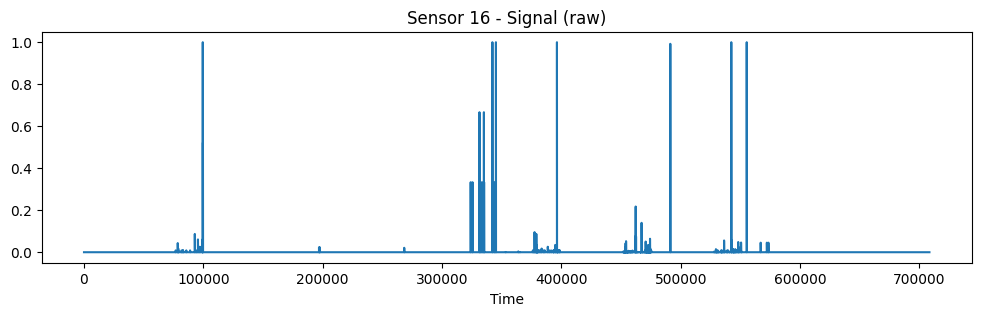

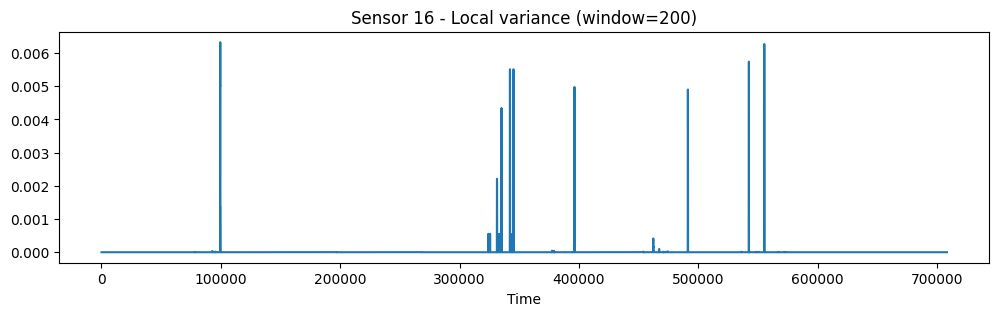

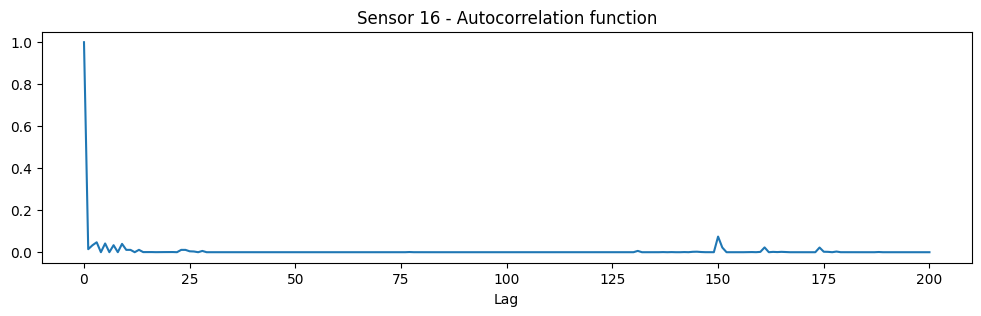

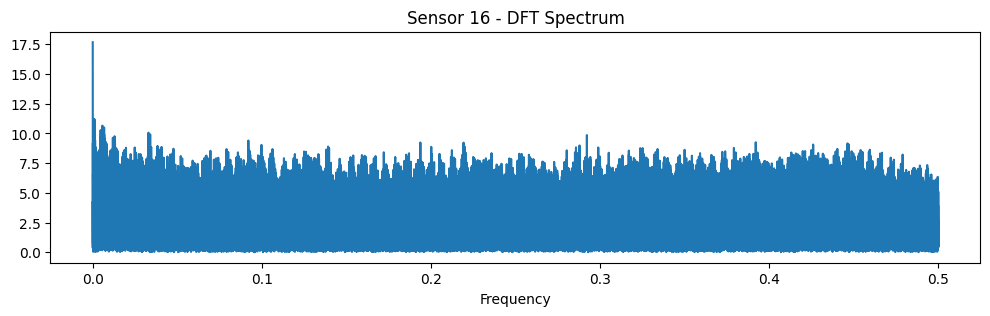

In [96]:
sensor_idx = 16
analyze(X_train_raw[:, sensor_idx], sensor_id=sensor_idx)

In [69]:
# construct edge_index for fully-connected graph

device = get_device()

D_features = X_train_raw.shape[1]  # nombre de capteurs / dimensions

# Nodes: 0, 1, ..., D_features-1
nodes = torch.arange(D_features, device=device)

# All possible pairs (i, j) with i < j
pairs = torch.combinations(nodes, r=2)          # shape (E, 2)

# Symetrization: add both (i, j) and (j, i)
row = torch.cat([pairs[:, 0], pairs[:, 1]])     # source
col = torch.cat([pairs[:, 1], pairs[:, 0]])     # cible

edge_index = torch.stack([row, col], dim=0)     # shape (2, E)
edge_index_sets = [edge_index]

print("edge_index shape:", edge_index.shape)
# Should print: (2, number_of_edges)

# Instantiate GDN with the paper's hyperparameters

node_num = D_features
INPUT_DIM = WINDOW_SIZE  # window size w

model = GDN(
    edge_index_sets=edge_index_sets,
    node_num=node_num,
    dim=128,                 # embedding dimension | original GDN: 64 or 128
    out_layer_inter_dim=128, # | original GDN: 64 or 128
    input_dim=INPUT_DIM,    # temporal window size | original GDN: 5
    out_layer_num=1,
    topk=25               # number of neighbors to keep in learned graph | original GDN: 15 or 30 | SMD 25
).to(device)

edge_index shape: torch.Size([2, 1406])


In [70]:
config = {
    'seed': 42,
    'decay': 0,
    'epoch': 50,
}

save_path = "./model_normal/gdn_smd_w_"+str(WINDOW_SIZE)+"_epoch"+str(config['epoch'])+".pth"
    

train_losses = train(
    model=model,
    save_path=save_path,
    config=config,
    train_dataloader=train_loader,
    val_dataloader=val_loader,      
    dataset_name='smd'
)

print("Training finished. Best model saved to:", save_path)

epoch (1 / 50) (Loss:0.00458600, ACU_loss:40.60905371)
epoch (2 / 50) (Loss:0.00357275, ACU_loss:31.63666543)
epoch (3 / 50) (Loss:0.00369135, ACU_loss:32.68686537)
epoch (4 / 50) (Loss:0.00351168, ACU_loss:31.09593274)
epoch (5 / 50) (Loss:0.00353523, ACU_loss:31.30448736)
epoch (6 / 50) (Loss:0.00328483, ACU_loss:29.08717119)
epoch (7 / 50) (Loss:0.00333991, ACU_loss:29.57491837)
epoch (8 / 50) (Loss:0.00310931, ACU_loss:27.53290921)
epoch (9 / 50) (Loss:0.00316765, ACU_loss:28.04956928)
epoch (10 / 50) (Loss:0.00304391, ACU_loss:26.95386361)
epoch (11 / 50) (Loss:0.00303010, ACU_loss:26.83153465)
epoch (12 / 50) (Loss:0.00315041, ACU_loss:27.89690253)
epoch (13 / 50) (Loss:0.00319129, ACU_loss:28.25888310)
epoch (14 / 50) (Loss:0.00311366, ACU_loss:27.57147191)
epoch (15 / 50) (Loss:0.00352925, ACU_loss:31.25152622)
epoch (16 / 50) (Loss:0.00315453, ACU_loss:27.93338295)
epoch (17 / 50) (Loss:0.00329184, ACU_loss:29.14924353)
epoch (18 / 50) (Loss:0.00348859, ACU_loss:30.89142248)
e

In [71]:
val_loss, val_result = test(model, val_loader)
test_loss, test_result = test(model, test_loader)
print(f"Validation Loss: {val_loss:.6f}")
print(f"Test Loss: {test_loss:.6f}")

pred_val, gt_val = val_result
pred_test, gt_test, labels_test = test_result

pred_val = np.array(pred_val)
gt_val = np.array(gt_val)
pred_test = np.array(pred_test)
gt_test = np.array(gt_test)
labels_test = np.array(labels_test)

Validation Loss: 0.012850
Test Loss: 0.012660


In [72]:
val_scores, val_err, val_a = compute_normalized_scores(pred_val, gt_val, smooth_window=10, use_sum=True)
test_scores, test_err, test_a = compute_normalized_scores(pred_test, gt_test, smooth_window=10, use_sum=True)

In [73]:
# Determine threshold from validation scores
threshold = np.percentile(test_scores, 99)  # 95th percentile

metrics = evaluate_anomaly_detection(test_scores, labels_test, threshold)

print("\n=== Anomaly Detection Performance on SMD (GDN) ===")
print(f"Precision : {metrics['precision']:.4f}")
print(f"Recall    : {metrics['recall']:.4f}")
print(f"F1-score  : {metrics['f1']:.4f}")
print(f"AUC       : {metrics['auc']:.4f}")


=== Anomaly Detection Performance on SMD (GDN) ===
Precision : 0.1970
Recall    : 0.0474
F1-score  : 0.0764
AUC       : 0.6602


In [74]:
best_f1 = 0.0
best_threshold = None
best_metrics = None

for th in np.linspace(np.min(test_scores), np.max(test_scores), num=50):
    metrics = evaluate_anomaly_detection(test_scores, labels_test, th)
    
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_threshold = th
        best_metrics = metrics

print("\n=== Best Anomaly Detection Performance on SMD (GDN) ===")
print(f"Precision : {best_metrics['precision']:.4f}")
print(f"Recall    : {best_metrics['recall']:.4f}")
print(f"F1-score  : {best_metrics['f1']:.4f}")
print(f"AUC       : {best_metrics['auc']:.4f}")
print(f"Threshold : {best_threshold:.4f}")


=== Best Anomaly Detection Performance on SMD (GDN) ===
Precision : 0.1687
Recall    : 0.1979
F1-score  : 0.1821
AUC       : 0.6602
Threshold : 19.7204


In [75]:
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# -----------------------------
# 1) Fit a multivariate VAR(100)
# -----------------------------

# X_train_raw : (T_train, D_features)
print("Train shape:", X_train_raw.shape)
print("Test  shape:", X_test_raw.shape)

# Fit VAR on training data
p = 100  # VAR order
print(f"\nFitting VAR({p}) on all {X_train_raw.shape[1]} sensors...")

var_model = VAR(X_train_raw)
var_results = var_model.fit(maxlags=p, ic=None, trend='c')  # fixed lag order
try:
    print(var_results.summary())
except np.linalg.LinAlgError:
    print("Warning: covariance not positive definite, skipping textual summary.")
# Effective order used (should be p)
print("VAR lag order used (k_ar):", var_results.k_ar)

# -----------------------------------------
# 2) One-step-ahead rolling forecast on test
# -----------------------------------------

T_test, D_features = X_test_raw.shape
k_ar = var_results.k_ar  # should be 100

# We keep a rolling history of the last k_ar true observations
history = list(X_train_raw[-k_ar:])  # list of length k_ar of vectors (D_features,)

test_pred = []  # will store one-step-ahead predictions for the test set

for t in range(T_test):
    # Take last k_ar observations as a (k_ar, D) array
    past = np.array(history[-k_ar:])   # shape (k_ar, D_features)
    
    # Forecast the next step (t+1)
    y_hat = var_results.forecast(past, steps=1)[0]  # shape (D_features,)
    test_pred.append(y_hat)
    
    # Update history with the *true* test point at time t
    history.append(X_test_raw[t])

test_pred = np.array(test_pred)  # shape (T_test, D_features)
test_true = X_test_raw.copy()    # shape (T_test, D_features)

print("\nForecast shapes:")
print("test_pred:", test_pred.shape)
print("test_true:", test_true.shape)

# --------------------------------------
# 3) Compute errors and anomaly scores
# --------------------------------------

# Absolute error per sensor
errors_per_sensor = np.abs(test_pred - test_true)  # shape (T_test, D_features)

# A simple global anomaly score: max error over sensors at each time
scores = errors_per_sensor.max(axis=1)  # shape (T_test,)

print("\nErrors / scores shapes:")
print("errors_per_sensor:", errors_per_sensor.shape)
print("scores:", scores.shape)
print("y_test_raw:", y_test_raw.shape)

# -------------------------------------------------
# 4) Evaluate anomaly detection (best F1 + AUC)
# -------------------------------------------------

labels = y_test_raw.astype(int)

# AUC ROC
auc = roc_auc_score(labels, scores)

# Sweep over thresholds to find best F1
ths = np.linspace(scores.min(), scores.max(), 200)
best_f1 = 0.0
best_th = None
best_prec = 0.0
best_rec = 0.0

for th in ths:
    y_pred = (scores > th).astype(int)
    f1 = f1_score(labels, y_pred, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_th = th
        best_prec = precision_score(labels, y_pred, zero_division=0)
        best_rec = recall_score(labels, y_pred, zero_division=0)

print("\n=== VAR(100) Anomaly Detection on SMAP (all sensors) ===")
print(f"AUC       : {auc:.4f}")
print(f"Best F1   : {best_f1:.4f}")
print(f"Precision : {best_prec:.4f}")
print(f"Recall    : {best_rec:.4f}")
print(f"Threshold : {best_th:.4f}")

# (Optionnel) Quelques stats sur scores normaux / anormaux
normal_scores   = scores[labels == 0]
anomaly_scores  = scores[labels == 1]
print("\nScore stats:")
print(f"  Normals  -> mean {normal_scores.mean():.4f}, median {np.median(normal_scores):.4f}")
print(f"  Anomalies-> mean {anomaly_scores.mean():.4f}, median {np.median(anomaly_scores):.4f}")

Train shape: (708405, 38)
Test  shape: (708420, 38)

Fitting VAR(100) on all 38 sensors...
VAR lag order used (k_ar): 100

Forecast shapes:
test_pred: (708420, 38)
test_true: (708420, 38)

Errors / scores shapes:
errors_per_sensor: (708420, 38)
scores: (708420,)
y_test_raw: (708420,)

=== VAR(100) Anomaly Detection on SMAP (all sensors) ===
AUC       : 0.7016
Best F1   : 0.1843
Precision : 0.1488
Recall    : 0.2420
Threshold : 0.1776

Score stats:
  Normals  -> mean 0.0726, median 0.0518
  Anomalies-> mean 0.1411, median 0.0941


In [49]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# -----------------------------
# 1. Charge une fois le dataset SMD
# -----------------------------
BASE_DIR = './data'
TRAIN_DATA_PATH = BASE_DIR + '/SMD/SMD/SMD_train.npy'
TEST_DATA_PATH  = BASE_DIR + '/SMD/SMD/SMD_test.npy'
TEST_LABEL_PATH = BASE_DIR + '/SMD/SMD/SMD_test_label.npy'

print("--- Loading SMD Raw Data ---")
try:
    X_train_raw = np.load(TRAIN_DATA_PATH)
    X_test_raw  = np.load(TEST_DATA_PATH)
    y_test_raw  = np.load(TEST_LABEL_PATH)
except FileNotFoundError as e:
    print(f"Error: {e}. Downloading SMD dataset via torch_timeseries...")
    from torch_timeseries.dataset import SMD
    SMD(root=BASE_DIR)
    print("SMD dataset downloaded.")
    X_train_raw = np.load(TRAIN_DATA_PATH)
    X_test_raw  = np.load(TEST_DATA_PATH)
    y_test_raw  = np.load(TEST_LABEL_PATH)

print("SMD Data Loaded Successfully.")
T_train, D_features = X_train_raw.shape
T_test,  _         = X_test_raw.shape
print(f"SMD train shape: {X_train_raw.shape}")
print(f"SMD test  shape: {X_test_raw.shape}")
print(f"SMD labels shape: {y_test_raw.shape}")

# -----------------------------
# 2. Fonction de création de fenêtres
# -----------------------------
def create_sliding_windows(data, window_size):
    """
    Creates overlapping sequences (sliding windows) from the time series data.
    Input:  (T, D)
    Output: (N_samples, D, Window_Size)
    """
    N_time, N_dims = data.shape
    windows = []
    for i in range(N_time - window_size):
        windows.append(data[i : i + window_size, :].T)  # (D, window_size)
    return np.array(windows)

# -----------------------------
# 3. Graph fully-connected (fixe pour tous les window sizes)
# -----------------------------
device = get_device()

nodes = torch.arange(D_features, device=device)
pairs = torch.combinations(nodes, r=2)          # (E, 2)

row = torch.cat([pairs[:, 0], pairs[:, 1]])     # source
col = torch.cat([pairs[:, 1], pairs[:, 0]])     # cible
edge_index = torch.stack([row, col], dim=0)     # (2, E)
edge_index_sets = [edge_index]

print("edge_index shape:", edge_index.shape)

# -----------------------------
# 4. Boucle sur différents WINDOW_SIZE
# -----------------------------
val_size   = 0.2
BATCH_SIZE = 64
EPOCHS     = 20
window_list = [20,100]  # 5, 10, ..., 100
auc_list    = []

for W in window_list:
    print("\n" + "="*60)
    print(f"Training GDN on SMD with WINDOW_SIZE = {W}")
    print("="*60)

    # ---- 4.1. Fenêtres glissantes pour ce W ----
    X_train_windows = create_sliding_windows(X_train_raw, W)
    X_test_windows  = create_sliding_windows(X_test_raw,  W)

    y_train_windows       = X_train_raw[W:, :]
    y_test_windows        = X_test_raw[W:, :]
    y_test_labels_windows = y_test_raw[W:]

    # ---- 4.2. Split validation depuis TRAIN ----
    N_train = X_train_windows.shape[0]
    N_val   = int(val_size * N_train)

    X_val_windows = X_train_windows[:N_val]
    y_val_windows = y_train_windows[:N_val]

    X_train_final = X_train_windows[N_val:]
    y_train_final = y_train_windows[N_val:]

    # ---- 4.3. Tensors & DataLoaders ----
    X_train_tensor       = torch.from_numpy(X_train_final).float()
    y_train_tensor       = torch.from_numpy(y_train_final).float()

    X_val_tensor         = torch.from_numpy(X_val_windows).float()
    y_val_tensor         = torch.from_numpy(y_val_windows).float()

    X_test_tensor        = torch.from_numpy(X_test_windows).float()
    y_test_tensor        = torch.from_numpy(y_test_windows).float()
    y_test_labels_tensor = torch.from_numpy(y_test_labels_windows).long()

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)
    test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor, y_test_labels_tensor)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

    # ---- 4.4. Modèle GDN pour ce W ----
    node_num = D_features
    INPUT_DIM = W

    model = GDN(
        edge_index_sets=edge_index_sets,
        node_num=node_num,
        dim=128,
        out_layer_inter_dim=128,
        input_dim=INPUT_DIM,
        out_layer_num=1,
        topk=25
    ).to(device)

    # ---- 4.5. Entraînement (20 epochs) ----
    config = {
        'seed': 42,
        'decay': 0,
        'epoch': EPOCHS,
    }

    save_path = f"./model_normal/gdn_smd_w_{W}_epoch{EPOCHS}.pth"

    train_losses = train(
        model=model,
        save_path=save_path,
        config=config,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        dataset_name='smd'
    )

    print("Training finished. Best model saved to:", save_path)

    # Recharge le meilleur modèle (early stopping)
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.to(device)

    # ---- 4.6. Évaluation val et test ----
    val_loss,  val_result  = test(model, val_loader)
    test_loss, test_result = test(model, test_loader)

    print(f"Validation Loss (W={W}): {val_loss:.6f}")
    print(f"Test Loss       (W={W}): {test_loss:.6f}")

    pred_val, gt_val = val_result
    pred_test, gt_test, labels_test = test_result

    pred_val    = np.array(pred_val)
    gt_val      = np.array(gt_val)
    pred_test   = np.array(pred_test)
    gt_test     = np.array(gt_test)
    labels_test = np.array(labels_test)

    # ---- 4.7. Scores d'anomalie + AUC ----
    # même protocole que ton code: smooth_window=10, use_sum=True
    val_scores,  val_err,  val_a  = compute_normalized_scores(
        pred_val,  gt_val,  smooth_window=10, use_sum=True
    )
    test_scores, test_err, test_a = compute_normalized_scores(
        pred_test, gt_test, smooth_window=10, use_sum=True
    )

    # Seuil déterminé sur la validation (comme annoncé dans le commentaire)
    best_f1 = 0.0
    best_threshold = None
    best_metrics = None
    for th in np.linspace(np.min(test_scores), np.max(test_scores), 100):
        metrics = evaluate_anomaly_detection(test_scores, labels_test, th)
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = th
            best_metrics = metrics

    metrics = best_metrics
    auc_list.append(metrics['auc'])

    print(f"AUC (W={W}) : {metrics['auc']:.4f}")
    print(f"Precision    : {metrics['precision']:.4f}")
    print(f"Recall       : {metrics['recall']:.4f}")
    print(f"F1           : {metrics['f1']:.4f}")
    print(f"Threshold    : {best_threshold:.4f}")


--- Loading SMD Raw Data ---
SMD Data Loaded Successfully.
SMD train shape: (708405, 38)
SMD test  shape: (708420, 38)
SMD labels shape: (708420,)
edge_index shape: torch.Size([2, 1406])

Training GDN on SMD with WINDOW_SIZE = 20
epoch (1 / 20) (Loss:0.00795889, ACU_loss:70.47598644)
epoch (2 / 20) (Loss:0.00645903, ACU_loss:57.19472873)
epoch (3 / 20) (Loss:0.00639824, ACU_loss:56.65643671)
epoch (4 / 20) (Loss:0.00648056, ACU_loss:57.38534488)
epoch (5 / 20) (Loss:0.00674330, ACU_loss:59.71195312)
epoch (6 / 20) (Loss:0.00746737, ACU_loss:66.12356432)
epoch (7 / 20) (Loss:0.00769711, ACU_loss:68.15794612)
epoch (8 / 20) (Loss:0.00719565, ACU_loss:63.71749750)
epoch (9 / 20) (Loss:0.00690185, ACU_loss:61.11592498)
epoch (10 / 20) (Loss:0.00705827, ACU_loss:62.50098316)
epoch (11 / 20) (Loss:0.00677906, ACU_loss:60.02854786)
epoch (12 / 20) (Loss:0.00644649, ACU_loss:57.08368815)
epoch (13 / 20) (Loss:0.00629163, ACU_loss:55.71234998)
epoch (14 / 20) (Loss:0.00617159, ACU_loss:54.64938

--- Loading SMD Raw Data ---
SMD Data Loaded Successfully.
SMD train shape:  (708405, 38)
SMD test  shape:  (708420, 38)
SMD labels shape:(708420,)
edge_index shape: torch.Size([2, 1406])

Evaluating saved GDN model with WINDOW_SIZE = 200
Loading weights from: ./model_normal/gdn_smd_w_200_epoch20.pth


/tmp/ipykernel_440171/186015671.py:157: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  gated_i = torch.arange(0, node_num).T.unsqueeze(1).repeat(1, topk_num).flatten().to(device).unsqueeze(0)


Validation Loss (W=200): 0.006800
Test Loss       (W=200): 0.006897
AUC ROC (W=200) = 0.6903


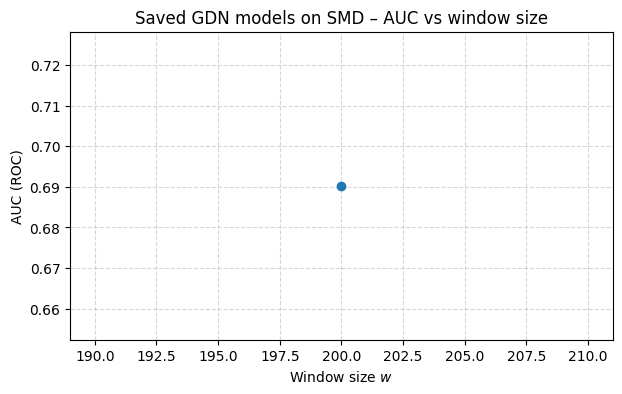

W=200 -> AUC=0.6903


In [47]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# --------------------------------------------------
# 1. Reload SMD once
# --------------------------------------------------
BASE_DIR = './data'
TRAIN_DATA_PATH = BASE_DIR + '/SMD/SMD/SMD_train.npy'
TEST_DATA_PATH  = BASE_DIR + '/SMD/SMD/SMD_test.npy'
TEST_LABEL_PATH = BASE_DIR + '/SMD/SMD/SMD_test_label.npy'

print("--- Loading SMD Raw Data ---")
X_train_raw = np.load(TRAIN_DATA_PATH)
X_test_raw  = np.load(TEST_DATA_PATH)
y_test_raw  = np.load(TEST_LABEL_PATH)

print("SMD Data Loaded Successfully.")
T_train, D_features = X_train_raw.shape
T_test,  _         = X_test_raw.shape
print(f"SMD train shape:  {X_train_raw.shape}")
print(f"SMD test  shape:  {X_test_raw.shape}")
print(f"SMD labels shape:{y_test_raw.shape}")

# --------------------------------------------------
# 2. Helper: sliding windows
# --------------------------------------------------
def create_sliding_windows(data, window_size):
    """
    Input:  (T, D)
    Output: (N_samples, D, window_size)
    """
    N_time, N_dims = data.shape
    windows = []
    for i in range(N_time - window_size):
        windows.append(data[i : i + window_size, :].T)
    return np.array(windows)

# --------------------------------------------------
# 3. Fixed fully-connected edge_index (same as avant)
# --------------------------------------------------
device = get_device()

nodes = torch.arange(D_features, device=device)
pairs = torch.combinations(nodes, r=2)

row = torch.cat([pairs[:, 0], pairs[:, 1]])
col = torch.cat([pairs[:, 1], pairs[:, 0]])
edge_index = torch.stack([row, col], dim=0)
edge_index_sets = [edge_index]

print("edge_index shape:", edge_index.shape)

# --------------------------------------------------
# 4. Loop over trained window sizes and compute AUC
# --------------------------------------------------
val_size   = 0.2
BATCH_SIZE = 64
EPOCHS     = 20   # mets 50 si tes fichiers sont avec epoch50

window_list = [200]  # w = 5,10,...,100
auc_list    = []

for W in window_list:
    model_path = f"./model_normal/gdn_smd_w_{W}_epoch{EPOCHS}.pth"
    if not os.path.exists(model_path):
        print(f"[WARN] Missing model for W={W}: {model_path} -> skipping")
        continue

    print("\n" + "="*60)
    print(f"Evaluating saved GDN model with WINDOW_SIZE = {W}")
    print(f"Loading weights from: {model_path}")
    print("="*60)

    # ---- 4.1. Build windows for this W ----
    X_train_windows = create_sliding_windows(X_train_raw, W)
    X_test_windows  = create_sliding_windows(X_test_raw,  W)

    y_train_windows       = X_train_raw[W:, :]
    y_test_windows        = X_test_raw[W:, :]
    y_test_labels_windows = y_test_raw[W:]

    # ---- 4.2. Validation split from TRAIN ----
    N_train = X_train_windows.shape[0]
    N_val   = int(val_size * N_train)

    X_val_windows = X_train_windows[:N_val]
    y_val_windows = y_train_windows[:N_val]

    X_train_final = X_train_windows[N_val:]
    y_train_final = y_train_windows[N_val:]

    # ---- 4.3. DataLoaders ----
    X_train_tensor       = torch.from_numpy(X_train_final).float()
    y_train_tensor       = torch.from_numpy(y_train_final).float()

    X_val_tensor         = torch.from_numpy(X_val_windows).float()
    y_val_tensor         = torch.from_numpy(y_val_windows).float()

    X_test_tensor        = torch.from_numpy(X_test_windows).float()
    y_test_tensor        = torch.from_numpy(y_test_windows).float()
    y_test_labels_tensor = torch.from_numpy(y_test_labels_windows).long()

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)
    test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor, y_test_labels_tensor)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

    # ---- 4.4. Recreate GDN and load weights ----
    node_num = D_features
    INPUT_DIM = W

    model = GDN(
        edge_index_sets=edge_index_sets,
        node_num=node_num,
        dim=128,
        out_layer_inter_dim=128,
        input_dim=INPUT_DIM,
        out_layer_num=1,
        topk=25
    ).to(device)

    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)

    # ---- 4.5. Get predictions on val & test ----
    val_loss,  val_result  = test(model, val_loader)
    test_loss, test_result = test(model, test_loader)

    print(f"Validation Loss (W={W}): {val_loss:.6f}")
    print(f"Test Loss       (W={W}): {test_loss:.6f}")

    pred_val, gt_val            = val_result
    pred_test, gt_test, y_test  = test_result

    pred_val = np.array(pred_val)
    gt_val   = np.array(gt_val)

    pred_test = np.array(pred_test)
    gt_test   = np.array(gt_test)
    y_test    = np.array(y_test)

    # ---- 4.6. Anomaly scores + AUC ----
    # même protocole que ton code: smooth_window=10, use_sum=True
    val_scores, _, _  = compute_normalized_scores(pred_val,  gt_val,
                                                  smooth_window=10, use_sum=True)
    test_scores, _, _ = compute_normalized_scores(pred_test, gt_test,
                                                  smooth_window=10, use_sum=True)

    # AUC ROC (seuil-indépendant)
    auc = roc_auc_score(y_test.astype(int), test_scores)
    auc_list.append((W, auc))

    print(f"AUC ROC (W={W}) = {auc:.4f}")

# --------------------------------------------------
# 5. Plot AUC vs window size
# --------------------------------------------------
if len(auc_list) == 0:
    print("No AUC computed (no models found?).")
else:
    auc_list = sorted(auc_list, key=lambda x: x[0])
    ws   = [w for (w, a) in auc_list]
    aucs = [a for (w, a) in auc_list]

    plt.figure(figsize=(7,4))
    plt.plot(ws, aucs, marker='o')
    plt.xlabel("Window size $w$")
    plt.ylabel("AUC (ROC)")
    plt.title("Saved GDN models on SMD – AUC vs window size")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    for w, a in auc_list:
        print(f"W={w:3d} -> AUC={a:.4f}")

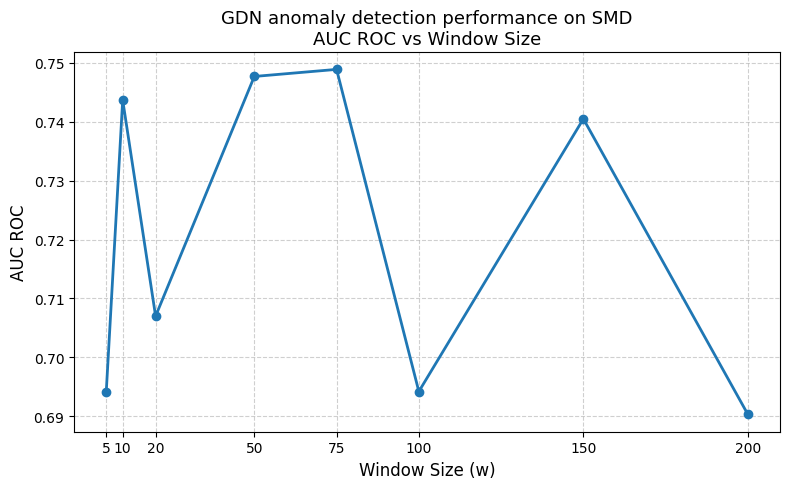

In [48]:
import matplotlib.pyplot as plt

# Window sizes you evaluated
window_sizes = [5, 10, 20, 50, 75, 100, 150, 200]

# Corresponding AUC ROC scores
auc_scores = [
    0.6941,  # W=5
    0.7437,  # W=10
    0.7070,  # W=20
    0.7477,  # W=50
    0.7489,  # W=75
    0.6942,  # W=100
    0.7405,  # W=150
    0.6903   # W=200
]

plt.figure(figsize=(8,5))
plt.plot(window_sizes, auc_scores, marker='o', linewidth=2)
plt.xlabel("Window Size (w)", fontsize=12)
plt.ylabel("AUC ROC", fontsize=12)
plt.title("GDN anomaly detection performance on SMD\nAUC ROC vs Window Size", fontsize=13)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(window_sizes)
plt.tight_layout()
plt.show()